In [1]:
# Importing libraries
import pandas as pd
import numpy as np


# graphs
import matplotlib.pyplot as plt
import seaborn as sns

# encoders, class analysers
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# data split
from sklearn.model_selection import train_test_split, KFold


# metrics to improve model valiadation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score


# hyperparameters search
from sklearn.model_selection import GridSearchCV

# Over and undersampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


# Models that will be tested
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
import datetime as dt
warnings.simplefilter('ignore')

In [2]:
# Functions used

def category_barplot(column, hue='default'):
    # the function takes in the string that is the
    # column and plots a countplot to visualise
    # the disctibution of classes
    fig, ax = plt.subplots(figsize=(5, 8))
    sns.countplot(x=column,
                  data=df,
                  hue=hue)
    plt.xticks(rotation=45)
    ax.set_title('Barplot for ' + column)
    plt.show()


def numerical_histplot(column, hue=None):
    # the function takes in a string that is the
    # column and plots a histplot for it
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.countplot(df[column], hue=hue)
    ax.set_title('Histplot for ' + column)
    plt.show()


def normalised_histplot(column):
    # the function takes in a string that is the
    # column and plots a histplot for it
    plt.figure()
    sns.distplot(df[column][df[column] > 0].dropna(), kde=False, rug=False)
    plt.title(column)
    plt.show()


def boxplot_numerical(column, target='default', sf=True):
    # the function takes in a string that is the
    # column and plots a boxblot depending on
    # the default flag
    fig, ax = plt.subplots(figsize=(10, 15))
    sns.boxplot(x=target,
                y=column,
                data=df,
                showfliers=sf)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + target + ' and ' + column)
    plt.show()


def clear_boxplot(column):
    # functions returns a boxplot for
    # visualisation of outliers and
    # numerical data distribution
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.boxplot(x=column,
                data=df)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def metrics(y_val, y_pred):
    # function takes in two arrays and returns
    # confusion matrix and some metrics
    # needed for model validation
    cm = confusion_matrix(y_val, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default', 'default'])
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')

    print('accuracy_score:', accuracy_score(y_val, y_pred))
    print('precision_score:', precision_score(y_val, y_pred))
    print('recall_score:', recall_score(y_val, y_pred))
    print('f1_score:', f1_score(y_val, y_pred))


def percentile(column):
    # the function returns lower and upper
    # boundary of a column of numerical values
    global upper_boundary, lower_boundary
    Q1 = df[column].quantile(0.25)
    Q2 = df[column].quantile(0.50)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_boundary = Q3 + 1.5*IQR
    lower_boundary = Q1 - 1.5*IQR
    print('Lower boundary:', lower_boundary)
    print('Upper boundary:', upper_boundary)


def if_weekend(x):
    # Function that returns the flag of filing an application on a weekend
    if x.weekday() in [5, 6]:
        return 1
    else:
        return 0


def percentage_of_defaulted(column, per='default'):
    # Function takes in the name of a categorical column and
    # returns the fraction of defaulted clients
    print('Fractions of defaulted clients in', column+':')
    display(df[
        df[per] == 1][column].value_counts()/df[
        df[per] == 0][column].value_counts())


def region_rating_to_category(i):
    if i == 20: return 0
    if i == 30: return 1
    if i == 40: return 2
    if i == 50: return 3
    if i == 60: return 4
    if i == 70: return 5
    if i == 80: return 6


current_date = dt.datetime.today()
upper_boundary = 0
lower_boundary = 0

The task is to build a model capable of prediction of wheather a bank's client is reliable enough to give them a loan. To do that a dataset with information about the clients is given, as well as dataset for validation of the model. The target metric is roc auc, but other metrics will be used to increase the efficiency of the model.

# 1. Loading dataset
In this segment the dataset will be loaded and briefly looked on. The columns will be separated into numerical, binary and categorical, and later analysed more in depth. The validation dataset will be loaded as well and merged with the training dataset to simplify EDA and Feature Engineering, with a respective flag to separate the validation dataset rows from the training dataset rows.

In [3]:
df_model = pd.read_csv('train.csv')  # training dataset
df_model['building_model'] = 1  # training flag
df_sub = pd.read_csv('test.csv')  # testing dataset
df_sub['building_model'] = 0  # training flag
df = df_model.append(df_sub, sort=False).reset_index(
    drop=True)
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,building_model
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


## 1.1 Checking for NaN values and data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

NaN values present only in education columns, other than that the dataset seems to be clear. For this model, to fill the education NaN values imputation will take place. 

The null-values in default come from the validation dataset, so they are ignored.

## 1.2 Number of unique values in each column

In [5]:
# cheching how many unique values does each column have
for column in df.columns:
    print('Number of unique values in', column, '-', len(df[column].unique()))

Number of unique values in client_id - 110148
Number of unique values in app_date - 120
Number of unique values in education - 6
Number of unique values in sex - 2
Number of unique values in age - 52
Number of unique values in car - 2
Number of unique values in car_type - 2
Number of unique values in decline_app_cnt - 24
Number of unique values in good_work - 2
Number of unique values in score_bki - 102618
Number of unique values in bki_request_cnt - 40
Number of unique values in region_rating - 7
Number of unique values in home_address - 3
Number of unique values in work_address - 3
Number of unique values in income - 1207
Number of unique values in sna - 4
Number of unique values in first_time - 4
Number of unique values in foreign_passport - 2
Number of unique values in default - 3
Number of unique values in building_model - 2


Education actually has only 5 values, since in the previous block it was established that it has NaN values.
1. client_id - id if a client, each value is unique, useless for the model;
2. app_date - date of application, string that needs to be converted to datetime;
3. education - which level of education the client has, categorical;
4. sex - sex of a client, binary categorical;
5. car - does client have a car, binary categorical;
6. car_type - does client have an imported car, binary categorical;
7. decline_app_cnt - number of times when loan was rejected, numberical;
8. good_work - if a client has a job that is considered "good" by bank standarts, binary categorical;
9. score_bki - credit score of a client, numerical;
10. bki_request_cnt - number of requests to national bureau of credit histories, numerical;
11. region_rating - rating of a region, categorical;
12. home_address - category of home adress of a client, categorical;
13. work_address - category of work adress of a client, categorical;
14. income - income of a client, numerical;
15. sna - is client connected to another client of a bank, categorical;
16. first_time - how fresh is the information about the client, category;
17. foreign_passport - does client have a traveling passport, categorical binary;
18. default - has client ever defaulted before, categorical binary.

Based on these oservations 3 lists are made, containing names of numerical, categorical and binary columns:

In [6]:
binary = ['sex', 'car', 'car_type', 'good_work',
          'foreign_passport']
category = ['education', 'work_address', 'home_address',
            'sna', 'first_time']
numerical = ['age', 'decline_app_cnt', 'bki_request_cnt',
             'income', 'region_rating', 'score_bki']
all_categories = category + binary + ['default']

Default column is not included in binary nor category since it is a target value, but it is included in all categories should a quick look at all categories bee needed.

# 2. Data overview
In this section each column will be looked at and analysed.

## 2.1 Binary data
### 2.1a. Sex

F    61836
M    48312
Name: sex, dtype: int64

F    0.56139
M    0.43861
Name: sex, dtype: float64

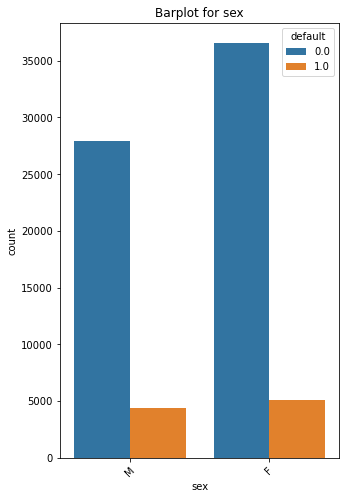

In [7]:
display(df.sex.value_counts())
display(df.sex.value_counts(normalize=True))
category_barplot('sex')

In [8]:
df[df.default == 1].sex.value_counts(normalize=True)

F    0.537665
M    0.462335
Name: sex, dtype: float64

In [9]:
percentage_of_defaulted('sex')

Fractions of defaulted clients in sex:


F    0.137968
M    0.155282
Name: sex, dtype: float64

It seems that there are slightly more female clients, and the similar ratio stays true for defaulted clients, yet it seems that a percantage of defaulted male clients is slightly higher that a percentage of defaulted female clients.

### 2.1b. car and car_type

N    74290
Y    35858
Name: car, dtype: int64

N    0.674456
Y    0.325544
Name: car, dtype: float64

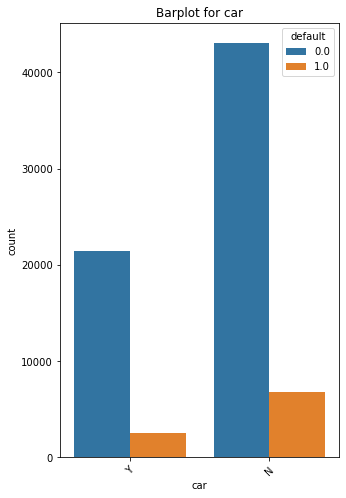

In [10]:
display(df.car.value_counts())
display(df.car.value_counts(normalize=True))
category_barplot('car')

N    89140
Y    21008
Name: car_type, dtype: int64

N    0.809275
Y    0.190725
Name: car_type, dtype: float64

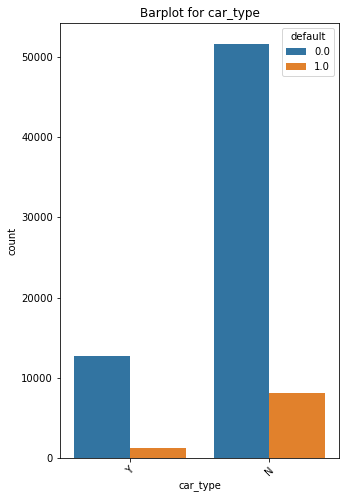

In [11]:
display(df.car_type.value_counts())
display(df.car_type.value_counts(normalize=True))
category_barplot('car_type')

In [12]:
df.loc[df.car == 'N'].car_type.value_counts()

N    74290
Name: car_type, dtype: int64

In [13]:
percentage_of_defaulted('car')

Fractions of defaulted clients in car:


N    0.158695
Y    0.118908
Name: car, dtype: float64

In [14]:
percentage_of_defaulted('car_type')

Fractions of defaulted clients in car_type:


N    0.157753
Y    0.095830
Name: car_type, dtype: float64

Most clients of a bank do not have a car, while only a fifth of the clients have an imported car. As expected, if a client has a negative flag for car, they also have a negative flag for car_type, so the columns might be combined later on.
The clients who have a car default less often, than the clients who do not, and it seems that clients who have an imported car default less often.
Will be looked at again together with income.

### 2.1c good_work

0    91917
1    18231
Name: good_work, dtype: int64

0    0.834486
1    0.165514
Name: good_work, dtype: float64

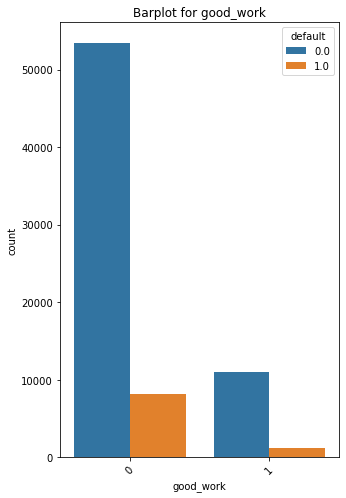

In [15]:
display(df.good_work.value_counts())
display(df.good_work.value_counts(normalize=True))
category_barplot('good_work')

In [16]:
percentage_of_defaulted('good_work')

Fractions of defaulted clients in good_work:


0    0.153947
1    0.104365
Name: good_work, dtype: float64

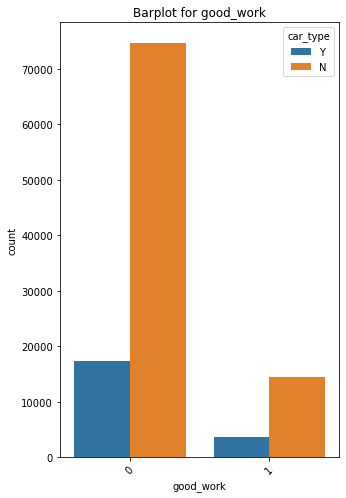

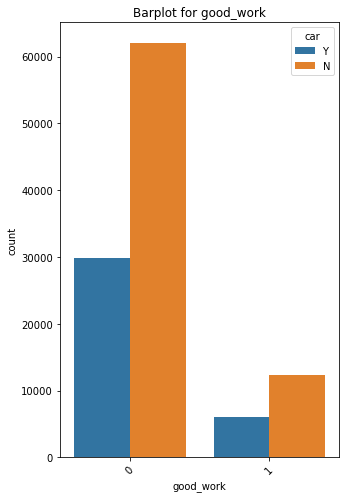

In [17]:
category_barplot('good_work', hue='car_type')
category_barplot('good_work', hue='car')

It seems that the bank has very strict definition of a good job. Those, who have a good job tend to default less often than the ones with normal jobs.
Those who have a good job also tend to have a normal and imported cars more often than the ones who have normal job.
Distribution of some numerical values depending on this flag will be looked on later on.

### 2.1d foreign_passport

N    93721
Y    16427
Name: foreign_passport, dtype: int64

N    0.850864
Y    0.149136
Name: foreign_passport, dtype: float64

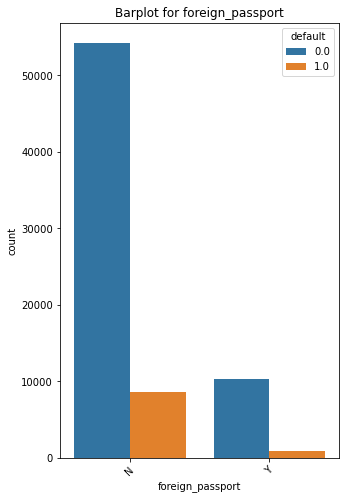

In [18]:
display(df.foreign_passport.value_counts())
display(df.foreign_passport.value_counts(normalize=True))
category_barplot('foreign_passport')

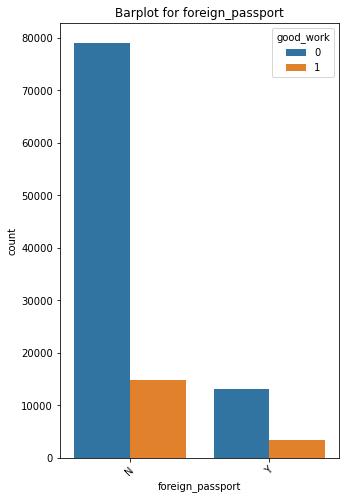

In [19]:
category_barplot('foreign_passport', hue='good_work')

In [20]:
percentage_of_defaulted('foreign_passport')

Fractions of defaulted clients in foreign_passport:


N    0.157841
Y    0.080031
Name: foreign_passport, dtype: float64

People who have foreign passports tend to default much less often, they also tend to have good work almost 50% more often relative to those, who do not.

## 2.2 Categorical data
### 2.2a. Education
Since this column has NaN values, imputation will be used. For now, it is going to be a mode imputation.

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

SCH    0.528841
GRD    0.317024
UGR    0.134476
PGR    0.017006
ACD    0.002653
Name: education, dtype: float64

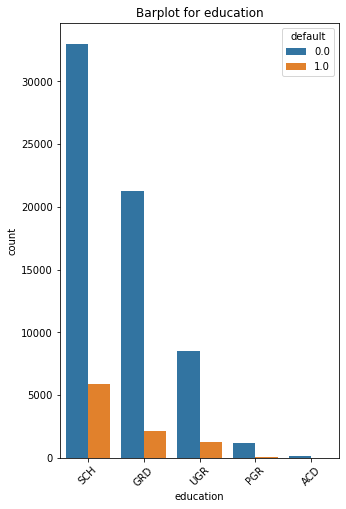

In [21]:
display(df.education.value_counts())
display(df.education.value_counts(normalize=True))
category_barplot('education')

In [22]:
# imputation
df.education = df.education.fillna(df.education.mode()[0])
df.education.isna().value_counts()

False    110148
Name: education, dtype: int64

In [23]:
display(df[df.default == 1].education.value_counts(normalize=True))
percentage_of_defaulted('education')

SCH    0.628148
GRD    0.224605
UGR    0.137751
PGR    0.008643
ACD    0.000854
Name: education, dtype: float64

Fractions of defaulted clients in education:


SCH    0.176893
GRD    0.099012
UGR    0.151437
PGR    0.068878
ACD    0.043011
Name: education, dtype: float64

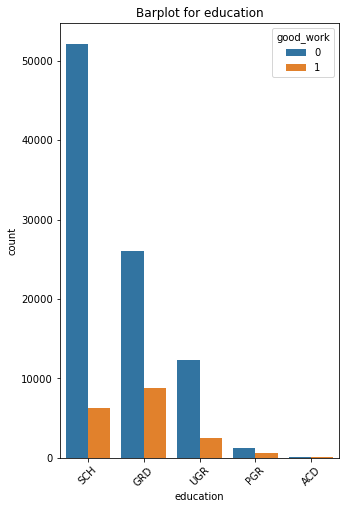

In [24]:
category_barplot('education', hue='good_work')

1. SCH - school;
2. UGR - undergraduate;
3. GRD - graduate;
4. PGR - masters;
5. ACD - doctorate;

It seems that the more educated the person is, the less likely they are to default. Overall the trend is that there are less people with higher education with the exception to the graduates, who outnumber undergraduates, yet the trend with
percentage of defaulted people stays true. 
People with better education tend to have a good job more often.

The data needs to be encoded, so the categories are replaced with numbers representing them:

In [25]:
df.education = df.education.apply(lambda x: 4 if x == 'ACD' else x)
df.education = df.education.apply(lambda x: 3 if x == 'PGR' else x)
df.education = df.education.apply(lambda x: 1 if x == 'UGR' else x)
df.education = df.education.apply(lambda x: 2 if x == 'GRD' else x)
df.education = df.education.apply(lambda x: 0 if x == 'SCH' else x)
display(df.education.value_counts())

0    58476
2    34768
1    14748
3     1865
4      291
Name: education, dtype: int64

### 2.2b. work and home addresses

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

3    0.609298
2    0.279270
1    0.111432
Name: work_address, dtype: float64

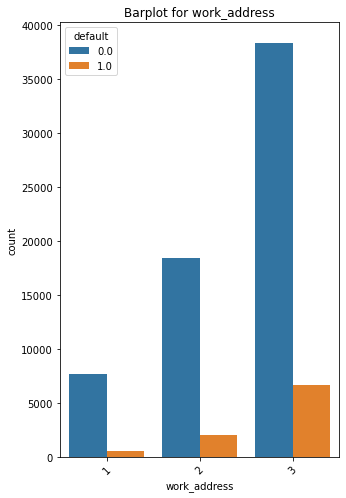

3    0.709774
2    0.224285
1    0.065941
Name: work_address, dtype: float64

Fractions of defaulted clients in work_address:


3    0.173650
2    0.114214
1    0.080093
Name: work_address, dtype: float64

In [26]:
display(df.work_address.value_counts())
display(df.work_address.value_counts(normalize=True))
category_barplot('work_address')
display(
    df[df.default == 1].work_address.value_counts(
        normalize=True
    )
)
percentage_of_defaulted('work_address')

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

2    0.541008
1    0.442023
3    0.016968
Name: home_address, dtype: float64

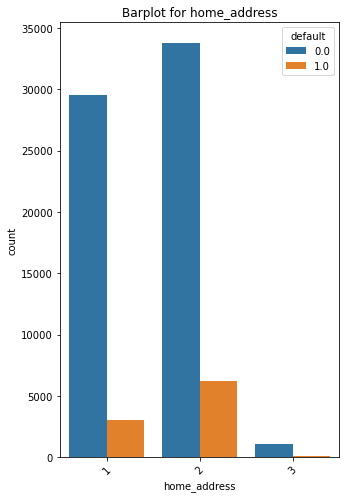

2    0.661438
1    0.322983
3    0.015578
Name: home_address, dtype: float64

Fractions of defaulted clients in home_address:


2    0.183636
1    0.102409
3    0.131295
Name: home_address, dtype: float64

In [27]:
display(df.home_address.value_counts())
display(df.home_address.value_counts(normalize=True))
category_barplot('home_address')
display(
    df[df.default == 1].home_address.value_counts(
        normalize=True
    )
)
percentage_of_defaulted('home_address')

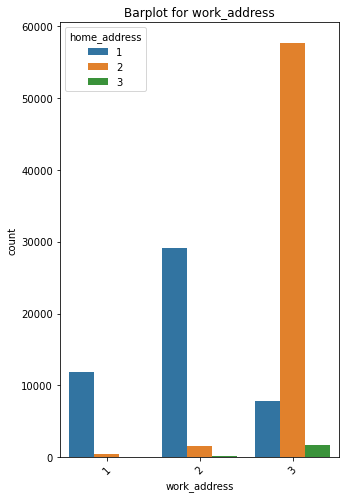

In [28]:
category_barplot('work_address', hue='home_address')

It is hard to interpret those categories since the coding is not given, yet it appears that the higher the work address category is, the higher the chances of default are. 

For home address the highest chances of default are for 2nd category, with 1st being the lowest.

For work address, the number of cleints fitting the latter categories seem to be higher, and they also tend to default less often.
It appears that the distribution of home address changes a lot depending on the category of work address - those who fit category 1 tend to have more people in category 1 for home address and no people who fit category 3. Those, who fit category 2 for work addresss tend to have more people in category 2 and 3 for home address, and for category 3 of work addresss the distribution is completely different - home address 2 became the largest group.

### 2.2c. SNA

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

1    0.641691
4    0.158705
2    0.143734
3    0.055870
Name: sna, dtype: float64

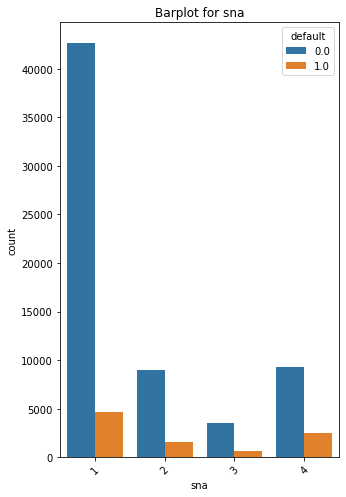

1    0.495625
4    0.265152
2    0.169868
3    0.069356
Name: sna, dtype: float64

Fractions of defaulted clients in sna:


1    0.108894
4    0.268243
2    0.176223
3    0.187158
Name: sna, dtype: float64

In [29]:
display(df.sna.value_counts())
display(df.sna.value_counts(normalize=True))
category_barplot('sna')
display(df[df.default == 1].sna.value_counts(normalize=True))
percentage_of_defaulted('sna')

It appears that the more connections the client has, the less likely he is to default, until it reaches category 4, where the default chances spike up to it's maximum. Potentially clients who have a high chance of default require gurantors from the bank.  It might be connected to first_time category.

### 2.2d. First time

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

3    0.422958
4    0.254358
1    0.166104
2    0.156580
Name: first_time, dtype: float64

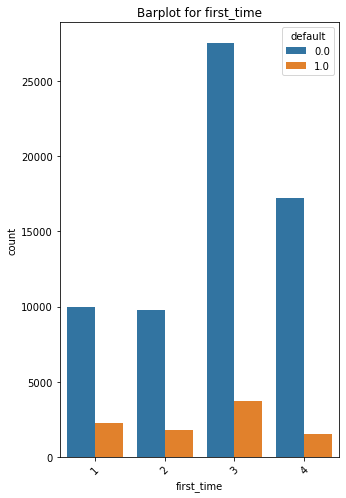

3    0.401088
1    0.243064
2    0.191848
4    0.163999
Name: first_time, dtype: float64

Fractions of defaulted clients in first_time:


1    0.228692
2    0.184033
3    0.136711
4    0.089360
Name: first_time, dtype: float64

In [30]:
display(df.first_time.value_counts())
display(df.first_time.value_counts(normalize=True))
category_barplot('first_time')
display(df[df.default == 1].first_time.value_counts(normalize=True))
percentage_of_defaulted('first_time')

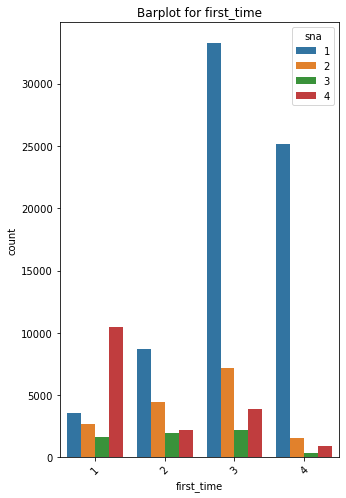

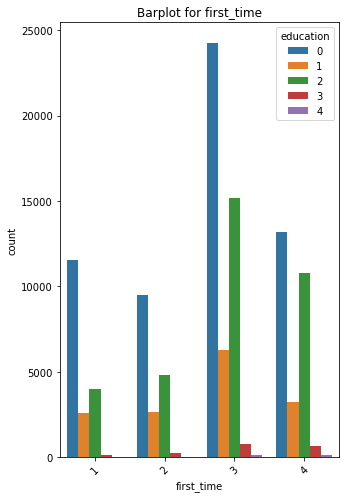

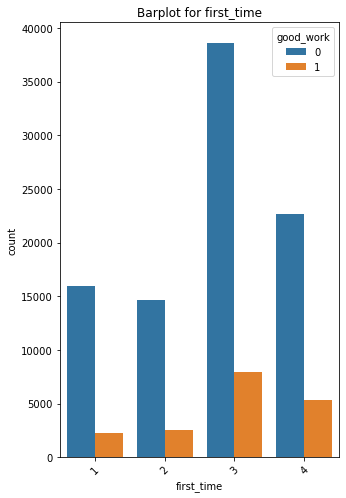

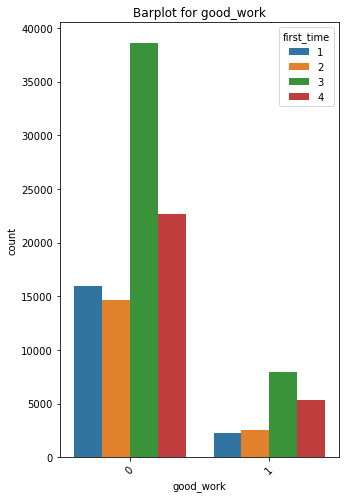

In [31]:
category_barplot('first_time', 'sna')
category_barplot('first_time', 'education')
category_barplot('first_time', 'good_work')
category_barplot('good_work', 'first_time')

A big percentage of clients fit the category 3, yet it seems that the higher this category is, the lower the chances of default are. 

Those who fit the category 1 tend to have a lot of connections amongst the other clients, probably - gurantors of some description. As the category first time goes up,sna distributiom starts to favour sna of 1 and 2, with category 4 of first time having sna of 1 and 2 going down a little bit.

The percentage of those who have a good job and fit category 1 or 2 in this column appears to be very close, and people who fit category 1 tend to have a good job less often. It also appears those who have a good work tend to fit first_time categories 1 and 2 less often, since they form a saller percentage of those, who have a good work.

Category 3 forms the highest percentage for all separations.

## 2.3 Numerical values
### 2.3.a Age

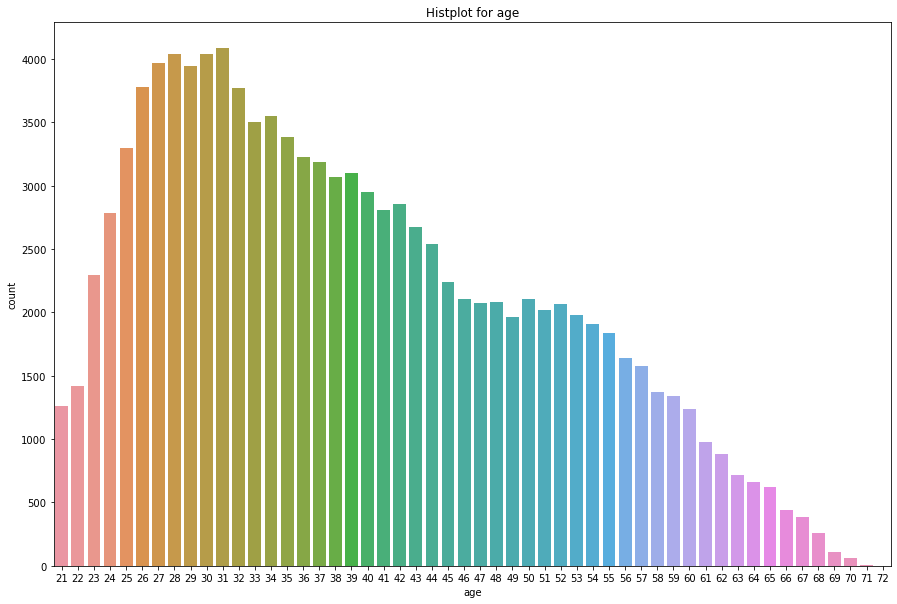

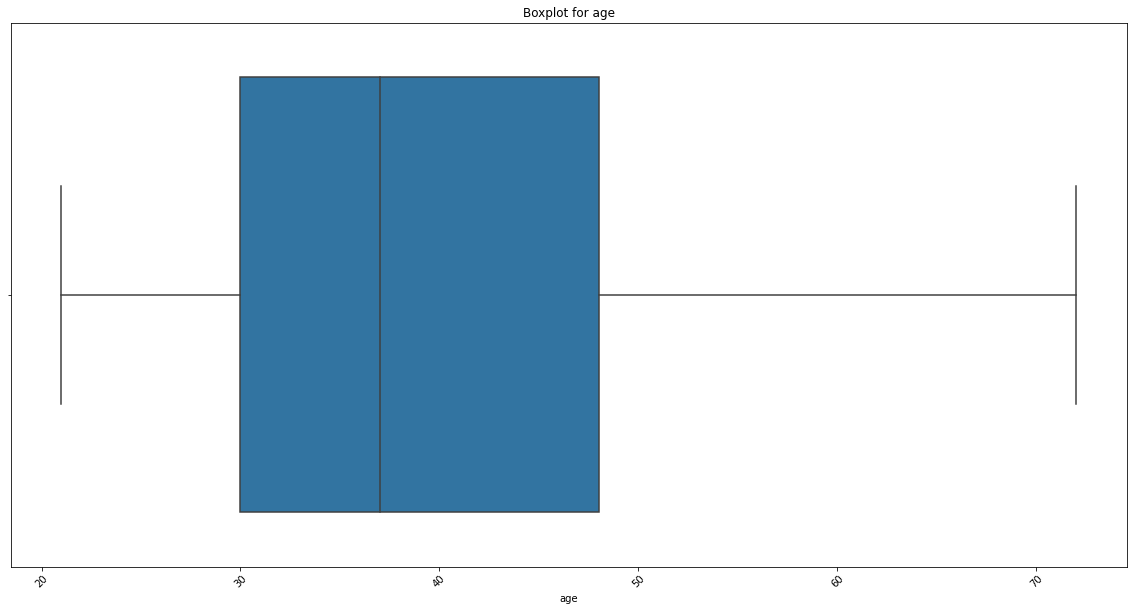

In [32]:
numerical_histplot('age')
clear_boxplot('age')

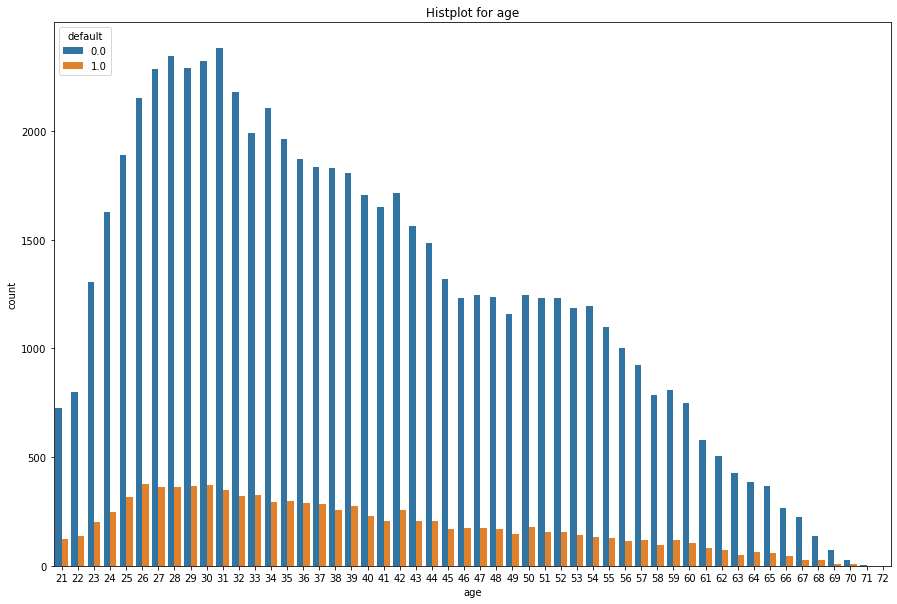

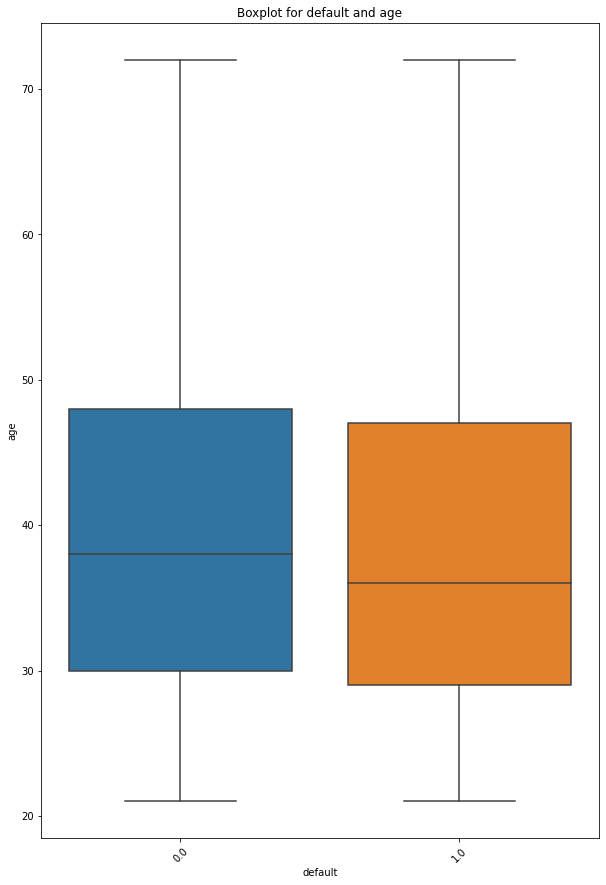

In [33]:
numerical_histplot('age', hue=df['default'])
boxplot_numerical('age')

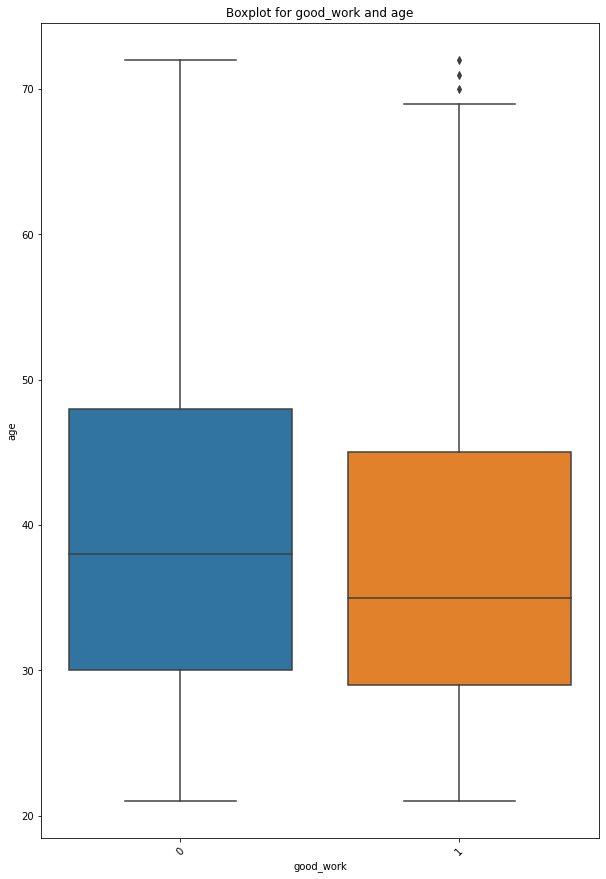

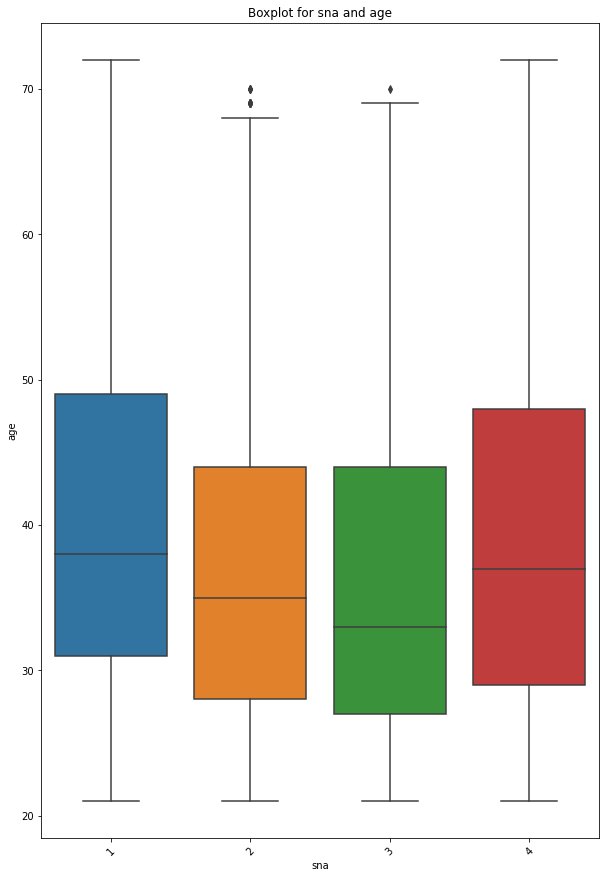

In [34]:
boxplot_numerical('age', 'good_work')
boxplot_numerical('age', 'sna')

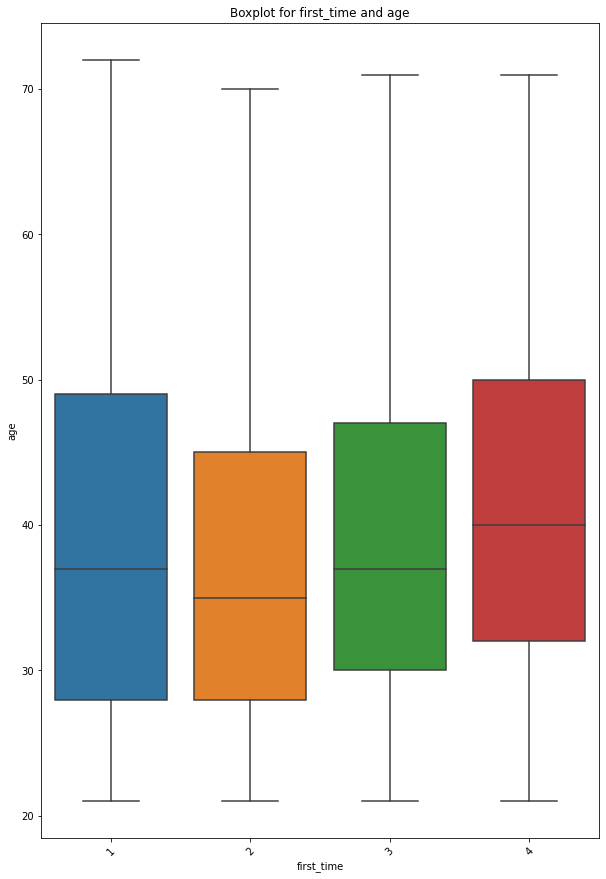

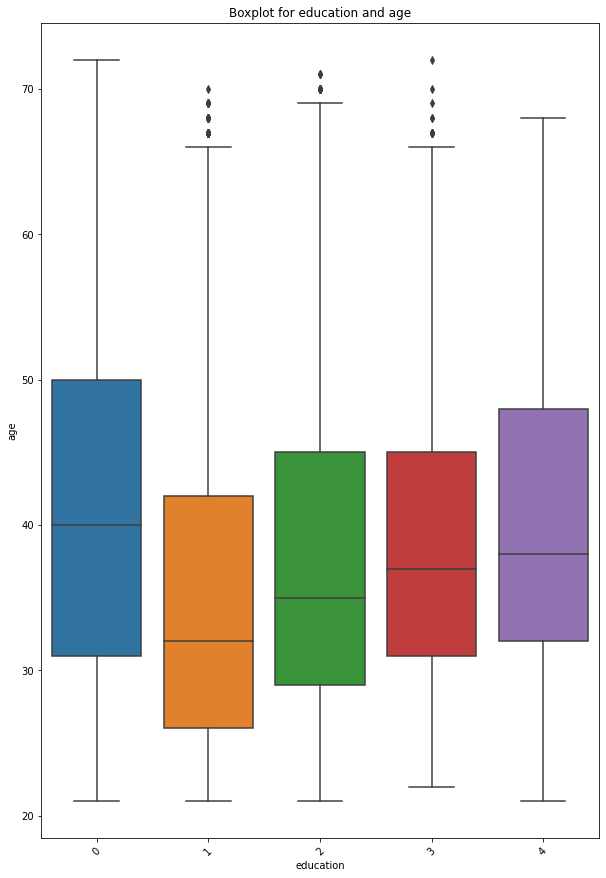

In [35]:
boxplot_numerical('age', 'first_time')
boxplot_numerical('age', 'education')

The age column has no outliers. It appears that the older people tend to default less often on average.
People who have good jobs tend to be younger, and people who have more connections also tend to be younger, with the exception for category 4 for SNA. Overall, the data has a slight left tail, so it can be logged in Feature Engineering section.
It also seems that usually people with better education are older, with the only exception being those, who only have school education.

### 2.3.b Count of declined applications

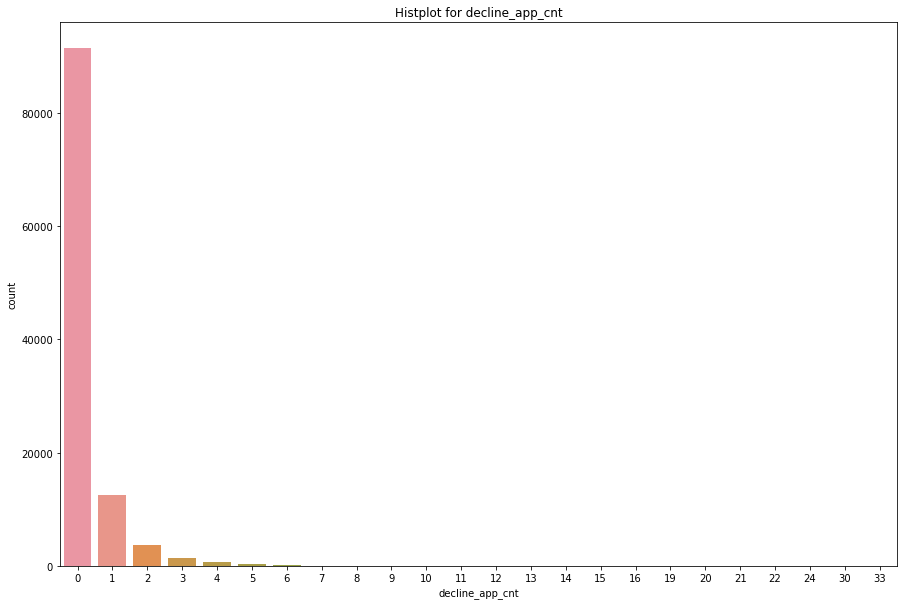

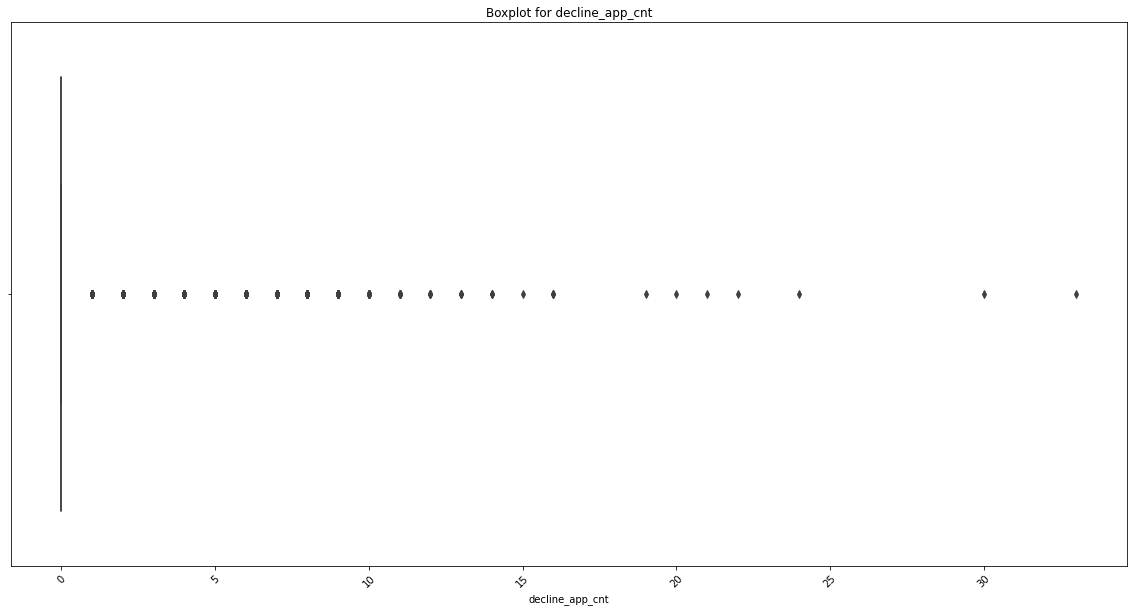

In [36]:
numerical_histplot('decline_app_cnt')
clear_boxplot('decline_app_cnt')

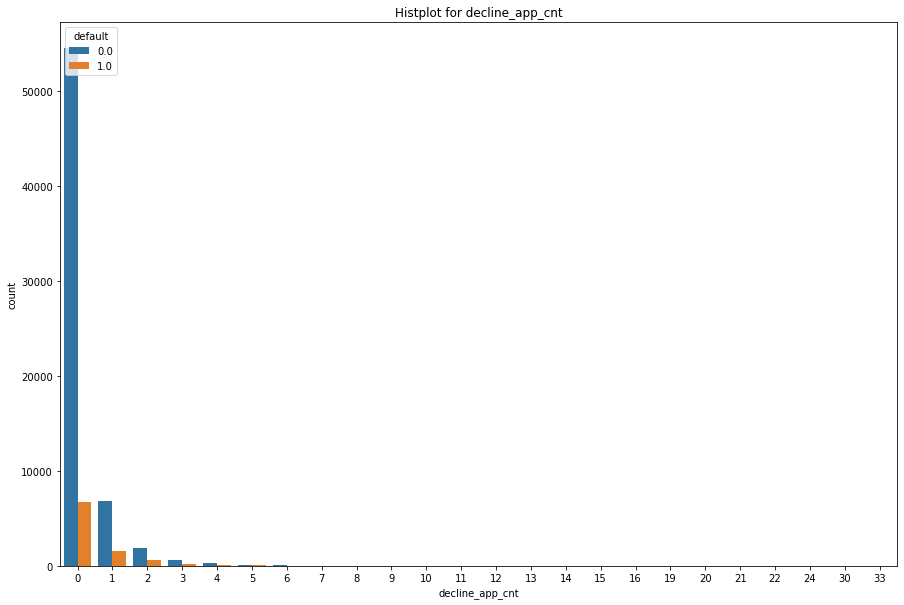

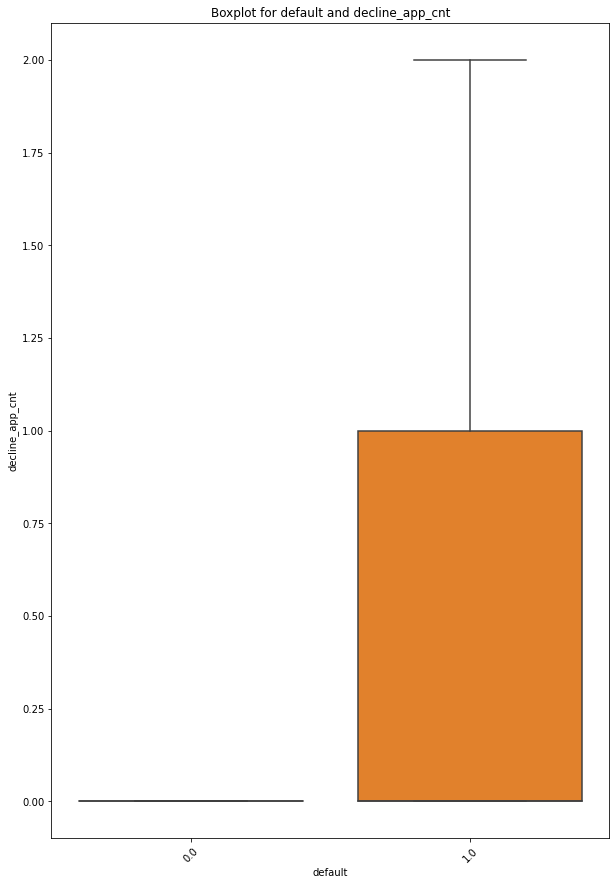

In [37]:
numerical_histplot('decline_app_cnt', hue=df['default'])
boxplot_numerical('decline_app_cnt', sf=False)

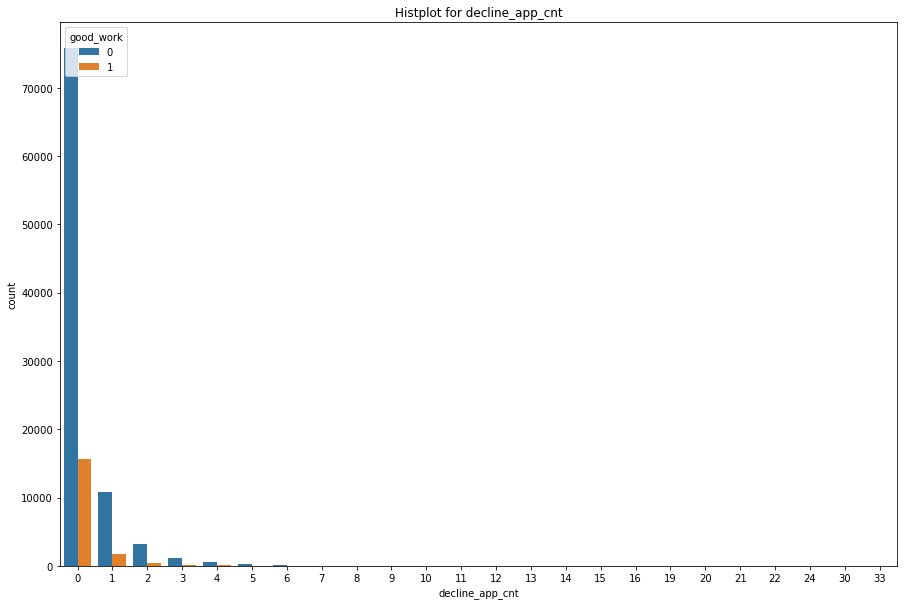

In [38]:
numerical_histplot('decline_app_cnt', hue=df['good_work'])

Most people do not get their applications rejected, yet it appears that if a client's application has been declined beofre, they are more likely to default. When this feature was combined with others, it showed boxlots with lower, upper boundaries and quartiles being the same as the median. It also appears that people with good jobs tend to have their applications rejected less often.
Because of a large number of values being 0, this column either will not be logged or a constant will be added before logging it.

### 2.3.c Credit Score Requests

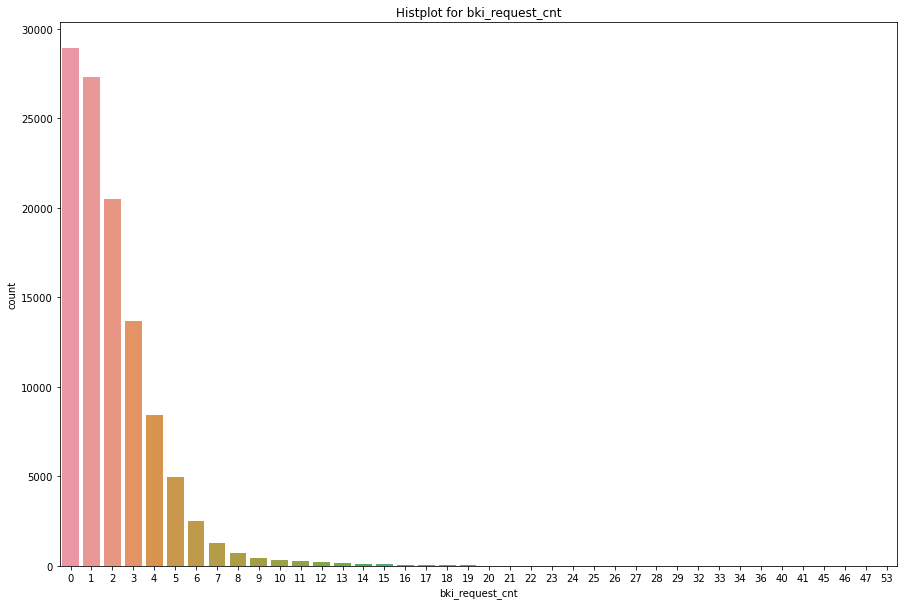

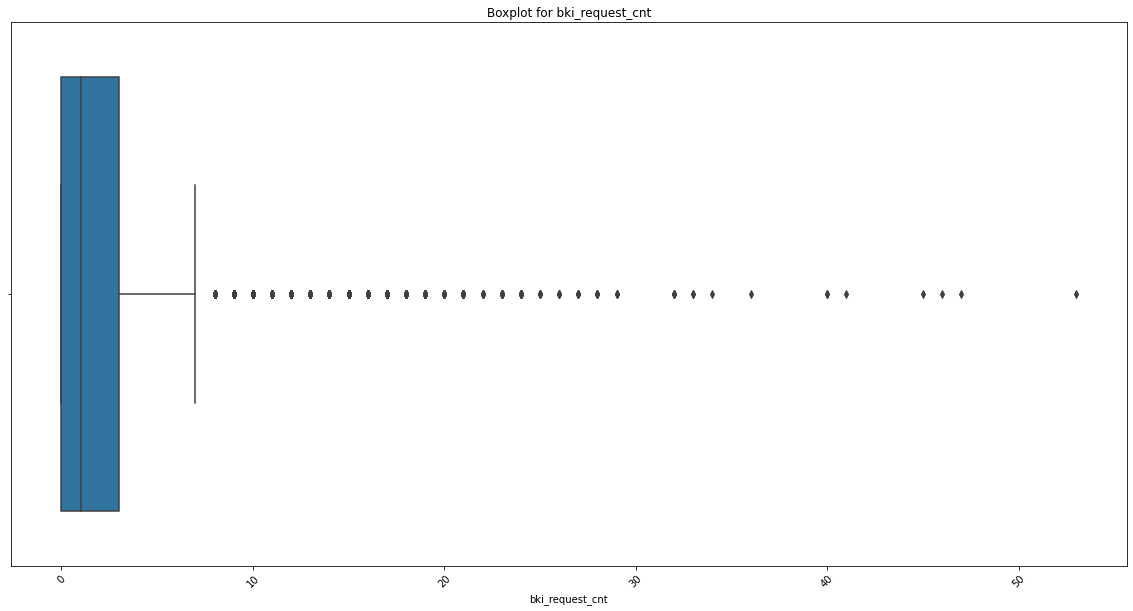

In [39]:
numerical_histplot('bki_request_cnt')
clear_boxplot('bki_request_cnt')

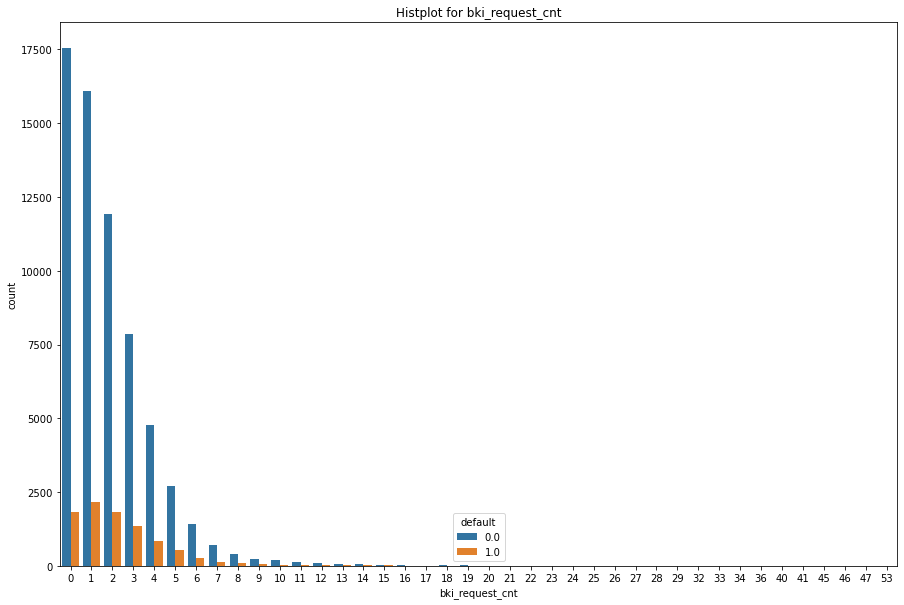

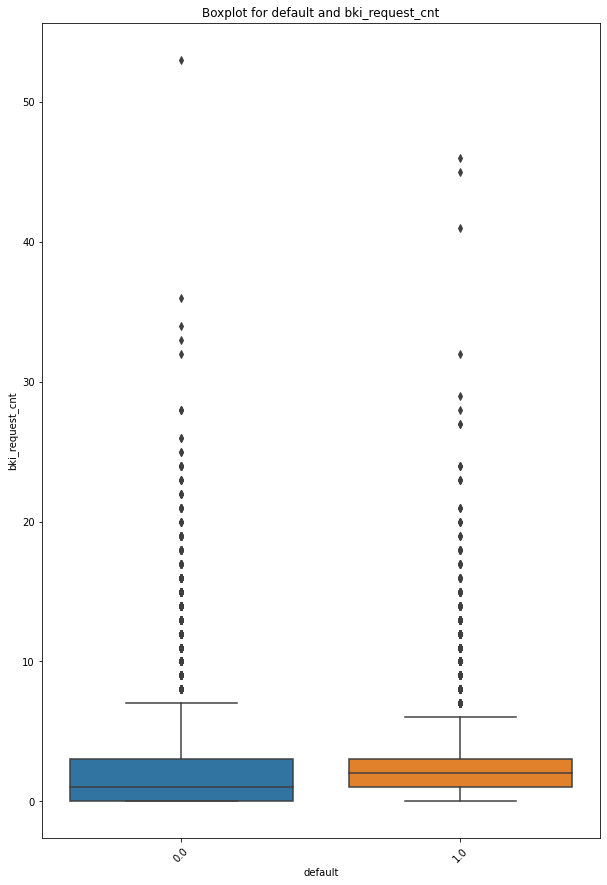

In [40]:
numerical_histplot('bki_request_cnt', hue=df['default'])
boxplot_numerical('bki_request_cnt')

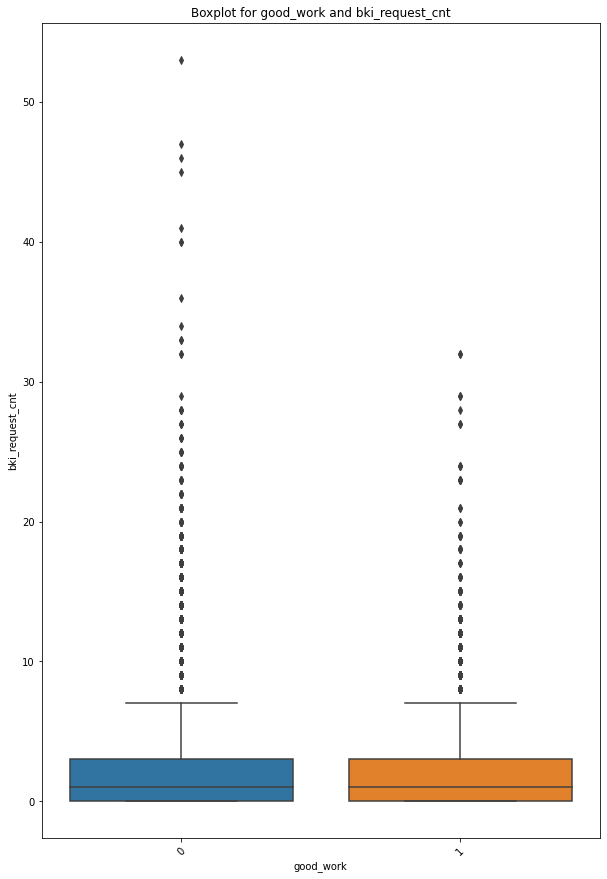

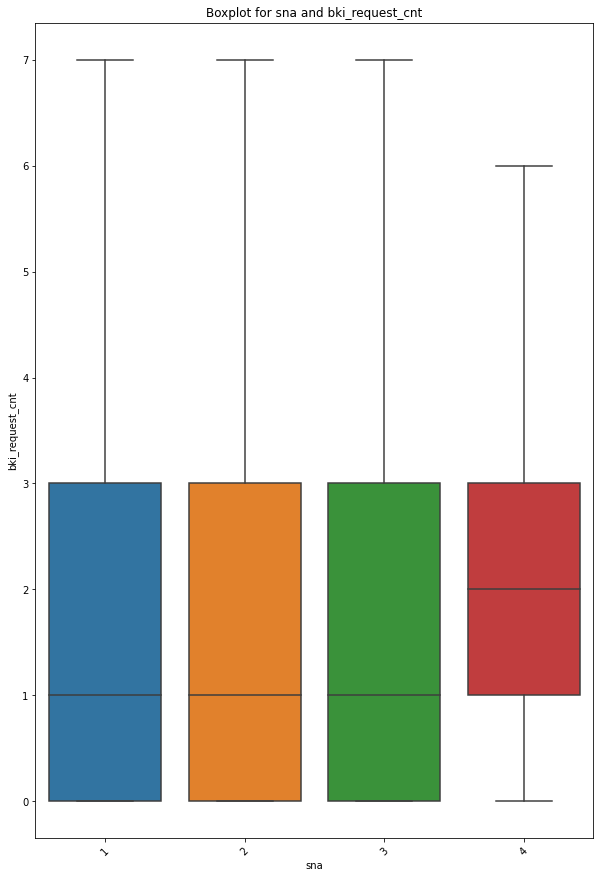

In [41]:
boxplot_numerical('bki_request_cnt', 'good_work', True)
boxplot_numerical('bki_request_cnt', 'sna', False)

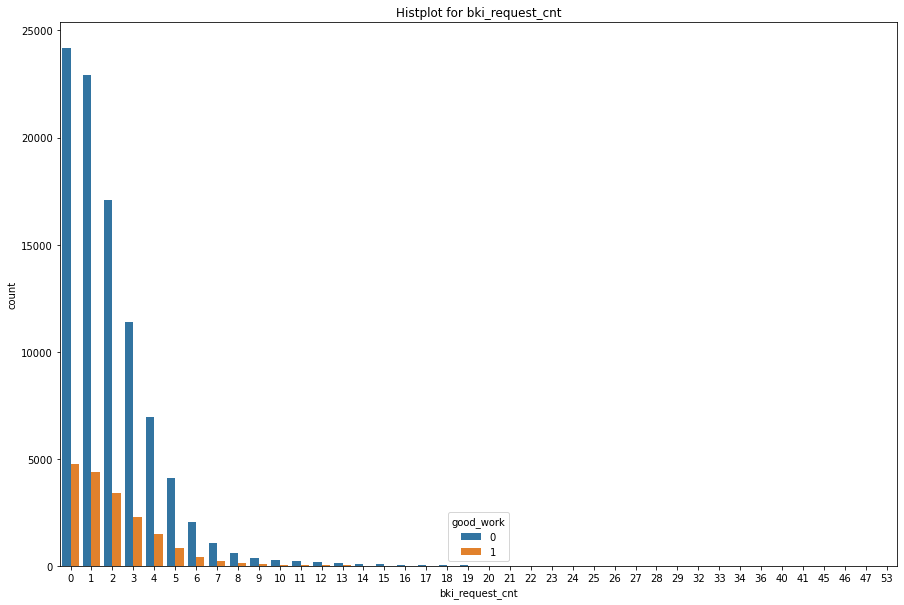

In [42]:
numerical_histplot('bki_request_cnt', hue=df['good_work'])

This column shows a similar trend to the previous one, having a strong left sided tail with a large spike at 0 and 1, but unlike the decline_app_cnt, the data is a bit more spread, so the lower and upper quartile are not the same as the mean, so the outliers might be removed.
If the data will be logged, same approach will need to be taken for this column - a constant will be added.

The spread of requests is slightlily smaller for defaulted clients, but the median is higher, so overall those who defaulted tend to have a few more credit score requests.

All the clients in different sna groups have the same distribution for requests, except for group 4, which has a slightly smaller spread and slightly higher median.

### 2.3.d Income

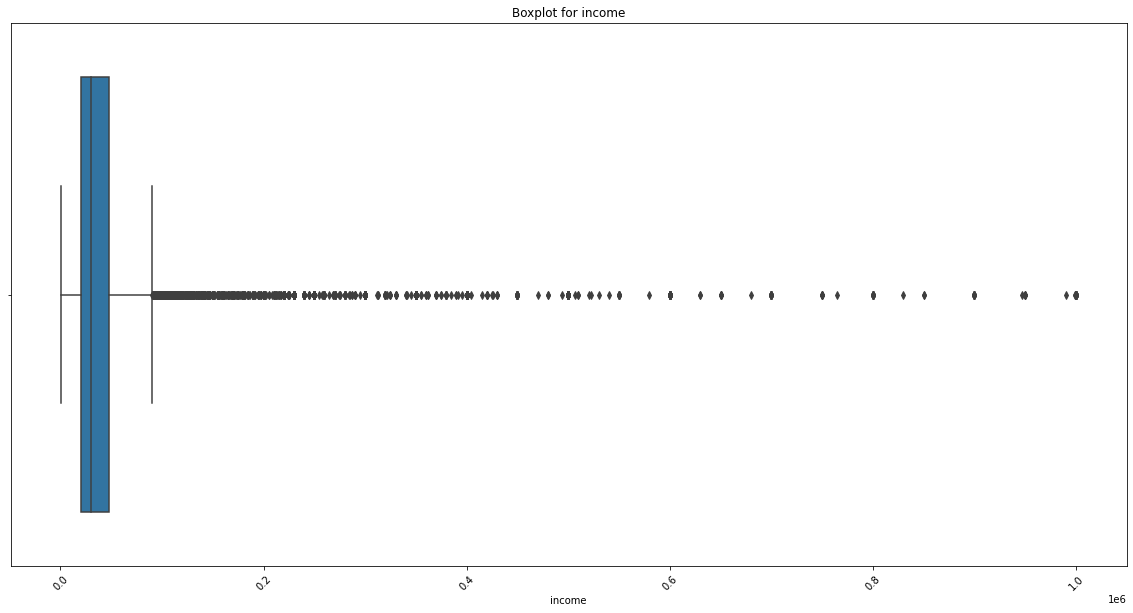

In [43]:
clear_boxplot('income')

Text(0, 0.5, 'Frequency')

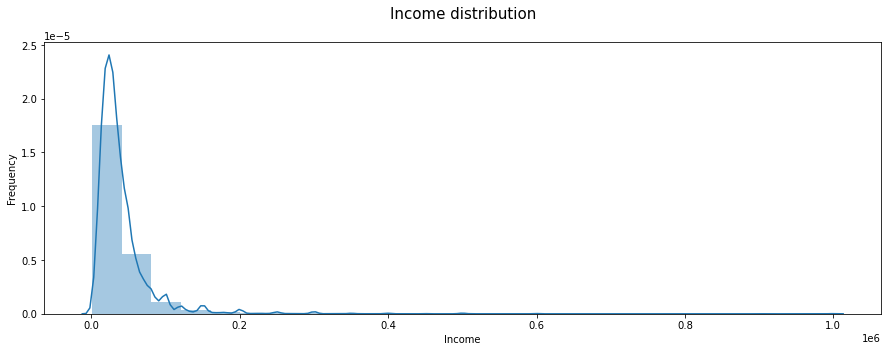

In [44]:
plt.figure(figsize=(15, 5))
sns.distplot(df.income.values, bins=25)
plt.title('Income distribution\n', fontsize=15)
plt.xlabel('Income')
plt.ylabel('Frequency')

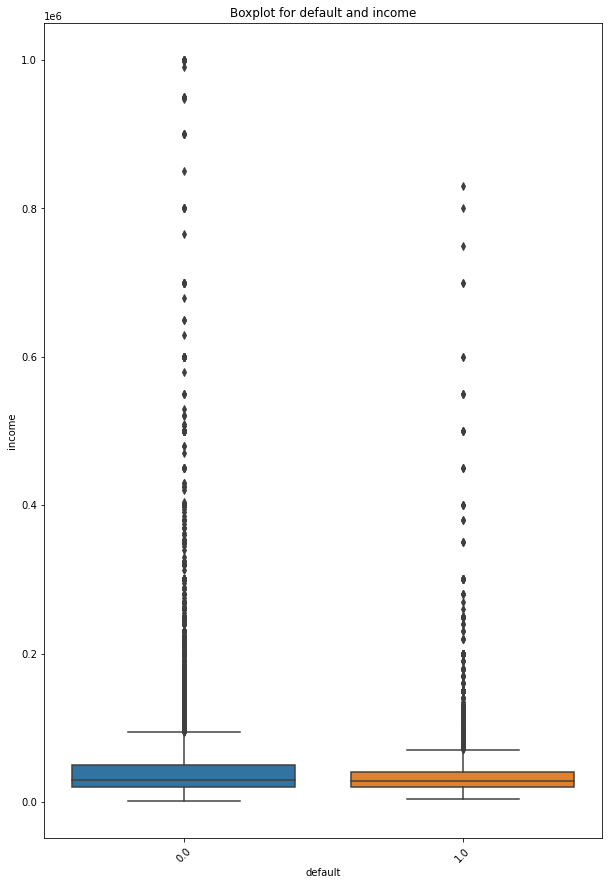

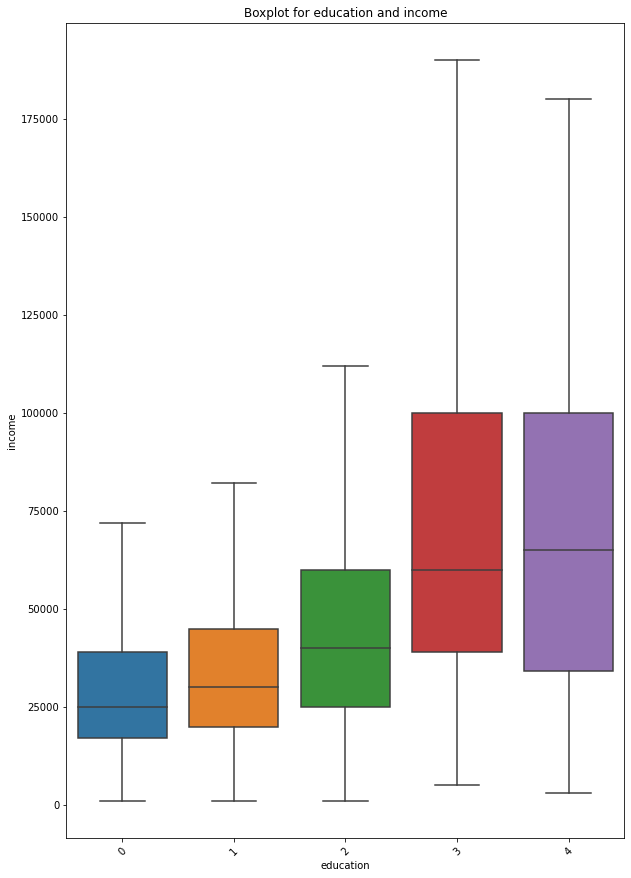

In [45]:
boxplot_numerical('income', sf=True)
boxplot_numerical('income', 'education', False)

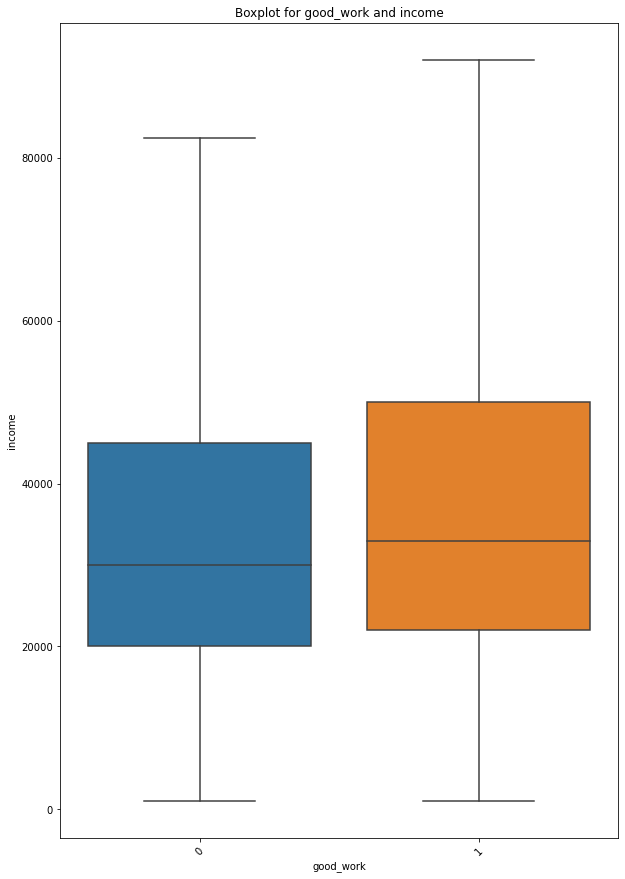

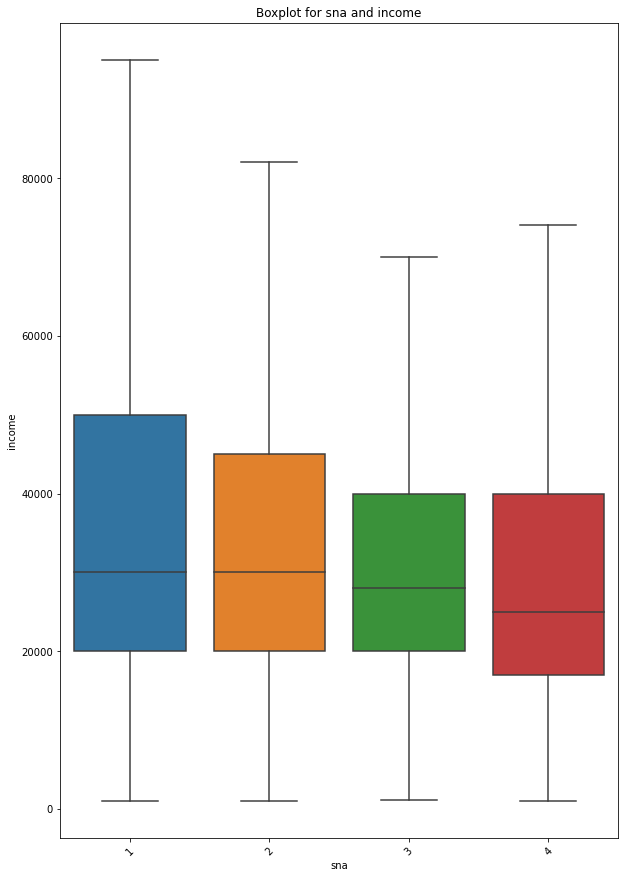

In [46]:
boxplot_numerical('income', 'good_work', False)
boxplot_numerical('income', 'sna', False)

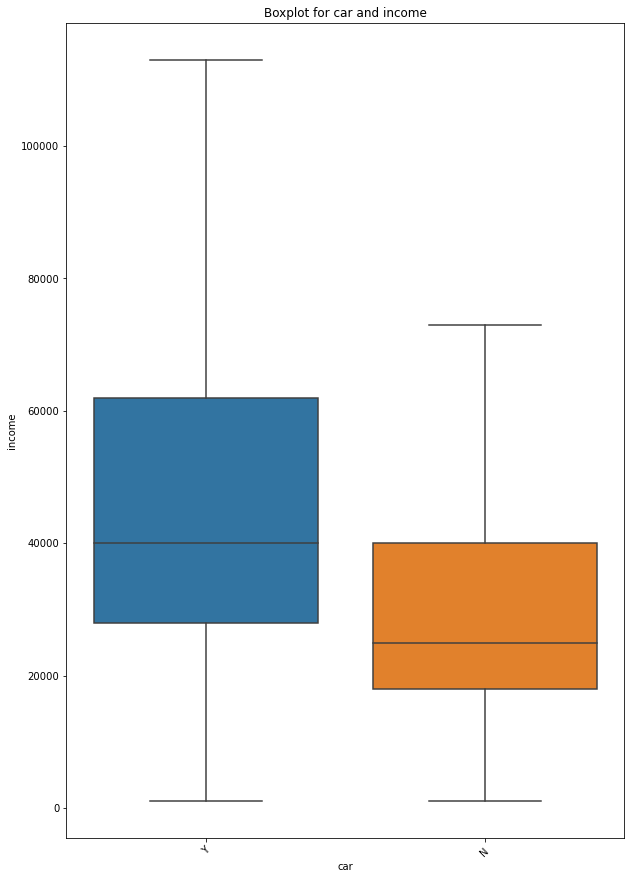

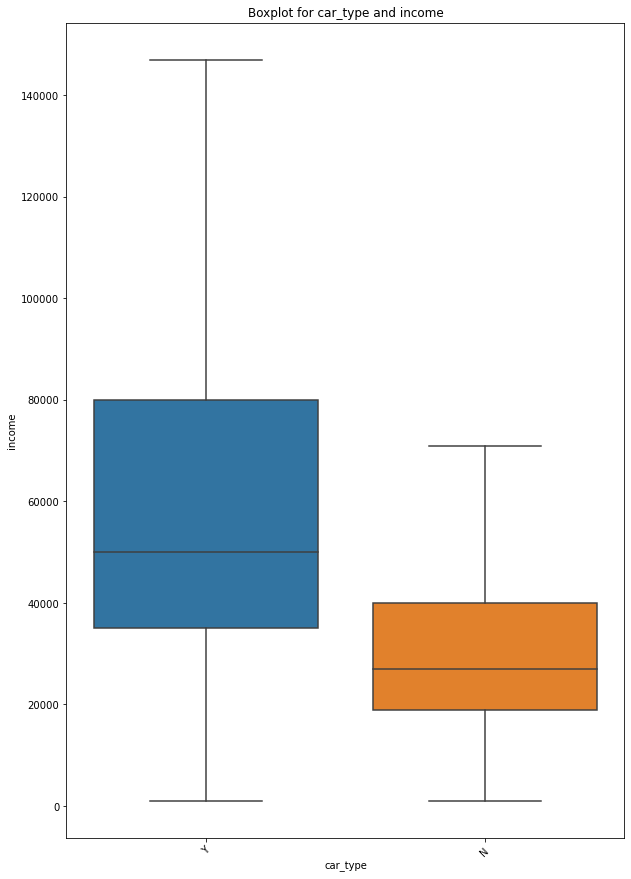

In [47]:
boxplot_numerical('income', 'car', False)
boxplot_numerical('income', 'car_type', False)

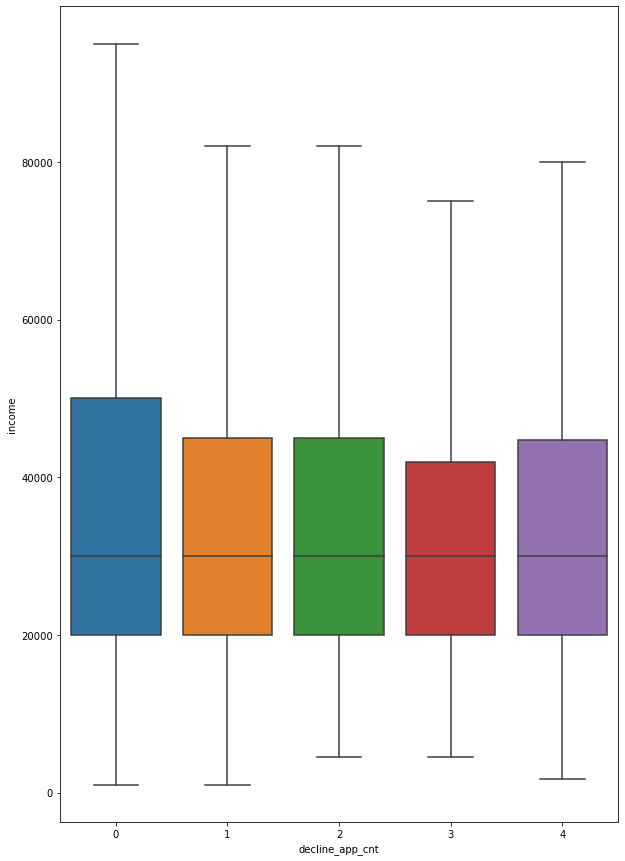

In [48]:
plt.figure(figsize=(10, 15))
sns.boxplot(x='decline_app_cnt',
            y='income',
            data=df[
                df.loc[:, 'decline_app_cnt'
                      ].isin(
                    df.loc[
                        :, 'decline_app_cnt'
                    ].value_counts().index[:5]
                )
            ],
            showfliers=False
)

The income data has a lot of outliers. Overall, it seems that the range of incomes of those clients who do not default is slightly broader than the range of those, who do. The median of  income of those who do not default is also slightly higher.

Those with a better education tend to have a higher income, and those who have good works tend to earn more as well.

Clients, who have closer connections with other clients of a bank tend to have lower income.

Clients, who have a car tend to have a larger income(median is about 1.5 times larger), and those who have an imported car tend to have even larger income, being almost twice over those, who do not have an imported car.

The income of the clients is similar on average for those who had their applications declined a few times, with only the upper boundaries changing. 

The values of income are a few orders of magnitude above the rest of numerial values, so it will be logged. 

### 2.3.e Credit Score(BKI score)

Text(0, 0.5, 'Frequency')

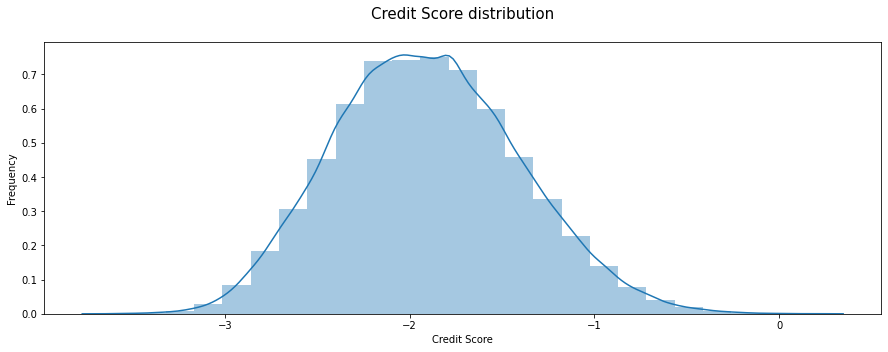

In [49]:
plt.figure(figsize=(15, 5))
sns.distplot(df.score_bki.values, bins=25)
plt.title('Credit Score distribution\n', fontsize=15)
plt.xlabel('Credit Score')
plt.ylabel('Frequency')

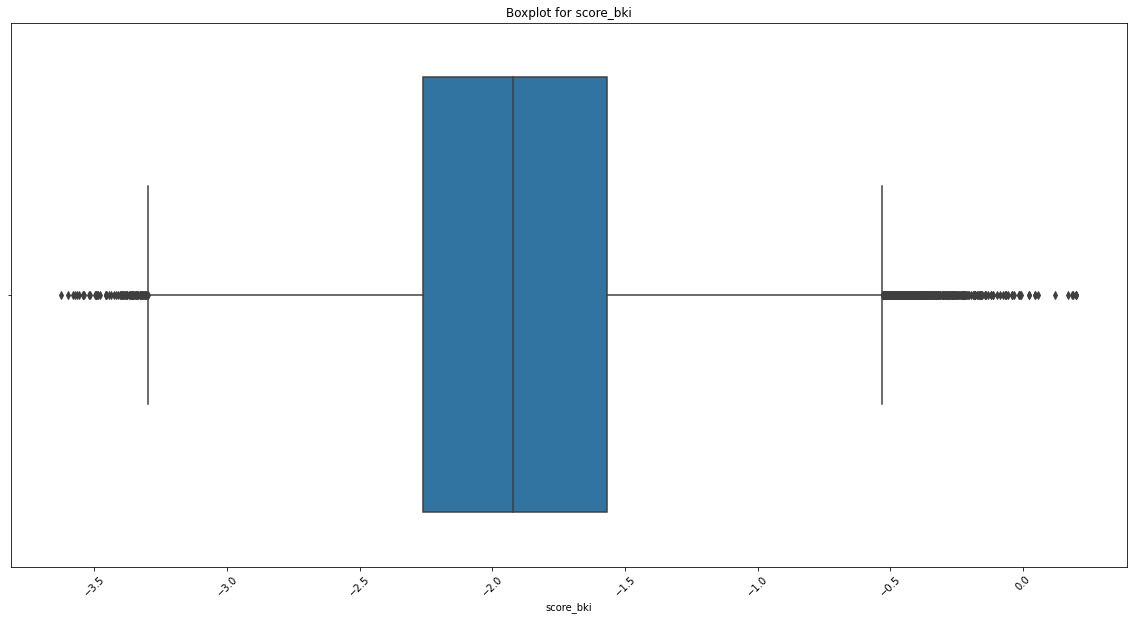

In [50]:
clear_boxplot('score_bki')

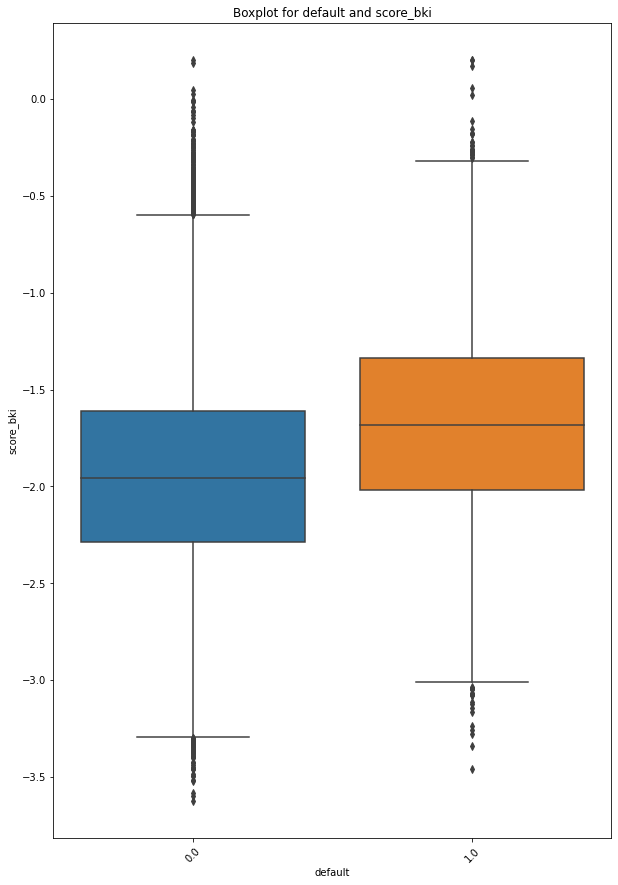

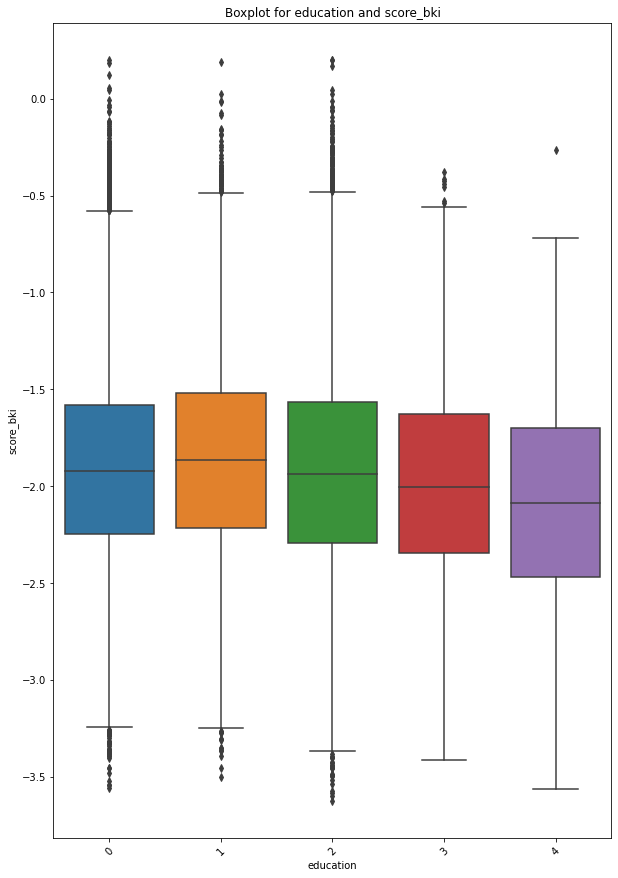

In [51]:
boxplot_numerical('score_bki', sf=True)
boxplot_numerical('score_bki', 'education', True)

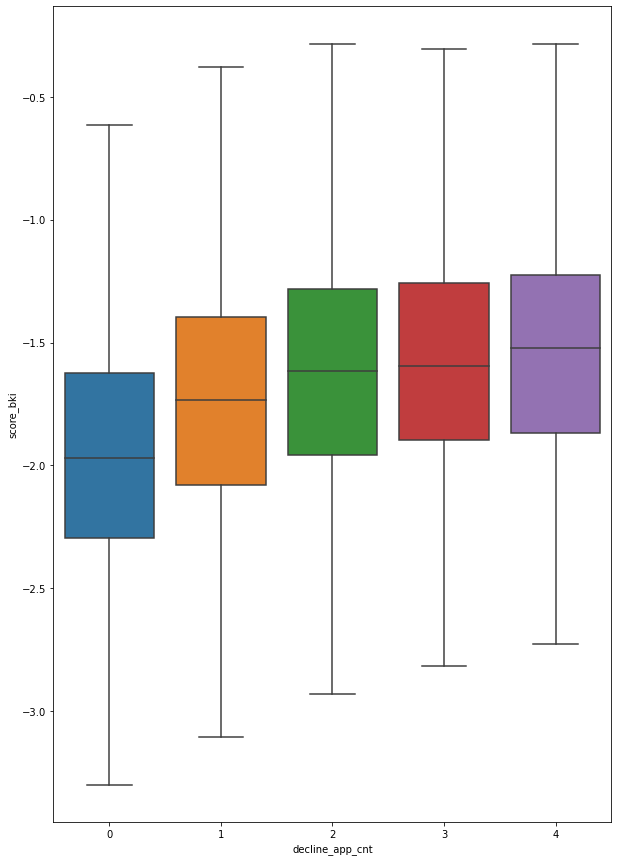

In [52]:
plt.figure(figsize=(10, 15))
sns.boxplot(x='decline_app_cnt',
            y='score_bki',
            data=df[
                df.loc[:, 'decline_app_cnt'
                      ].isin(
                    df.loc[
                        :, 'decline_app_cnt'
                    ].value_counts().index[:5]
                )
            ],
            showfliers=False
)

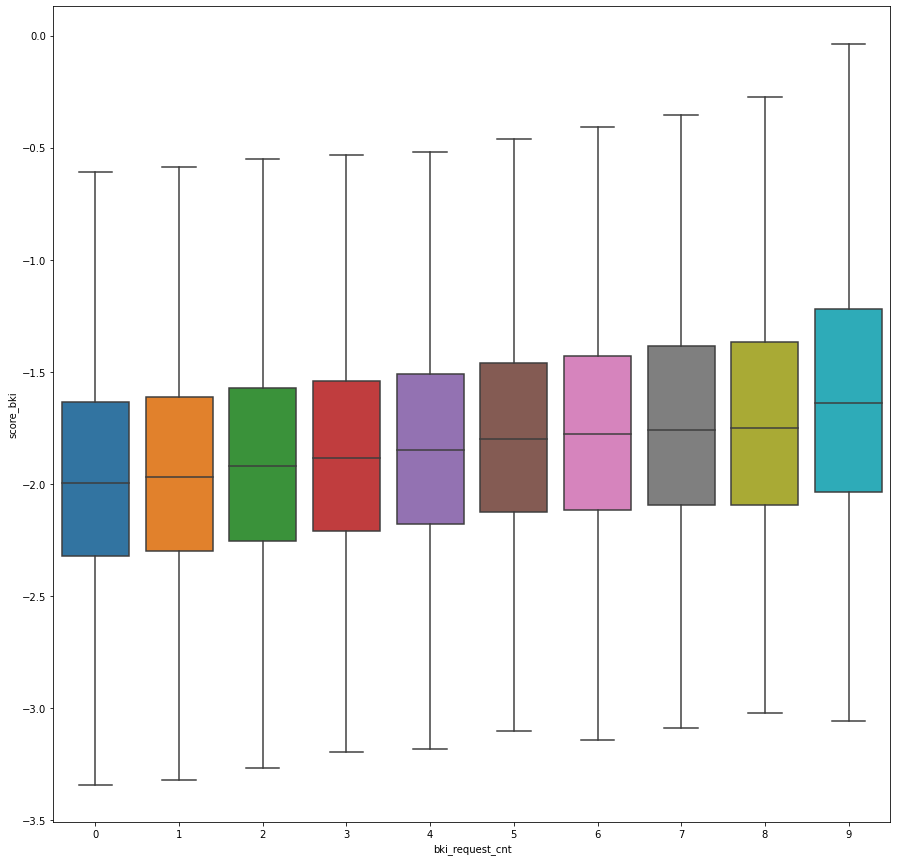

In [53]:
plt.figure(figsize=(15, 15))
sns.boxplot(x='bki_request_cnt',
            y='score_bki',
            data=df[
                df.loc[:, 'bki_request_cnt'
                      ].isin(
                    df.loc[
                        :, 'bki_request_cnt'
                    ].value_counts().index[:10]
                )
            ],
            showfliers=False
)

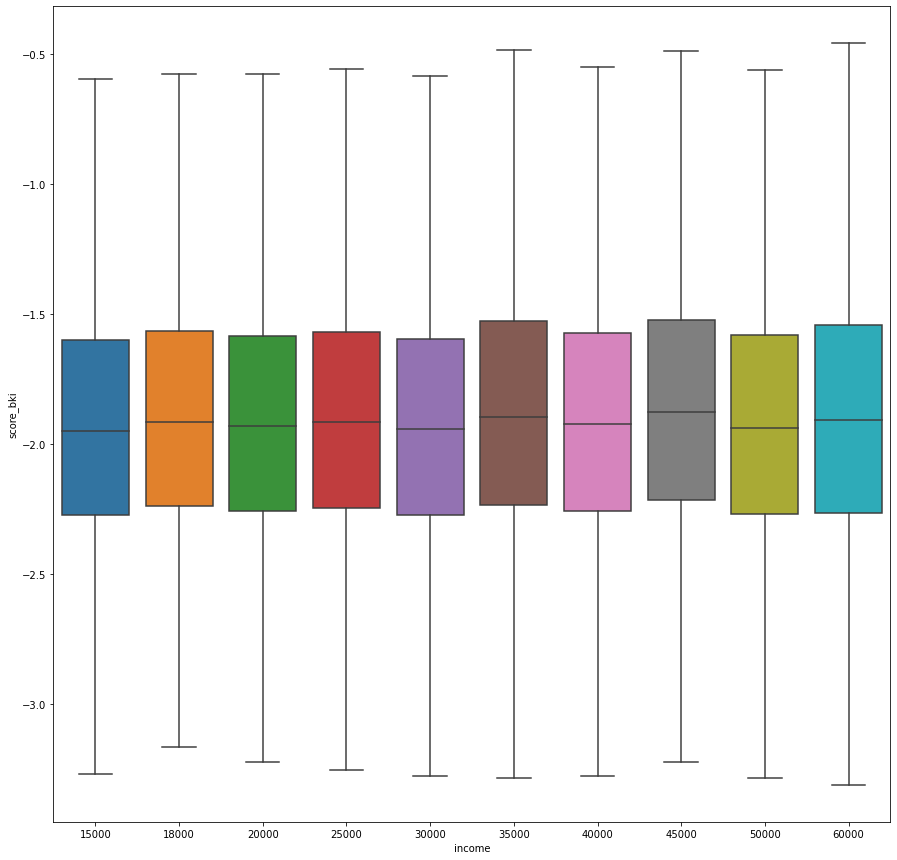

In [54]:
plt.figure(figsize=(15, 15))
sns.boxplot(x='income',
            y='score_bki',
            data=df[
                df.loc[:, 'income'
                      ].isin(
                    df.loc[
                        :, 'income'
                    ].value_counts().index[:10]
                )
            ],
            showfliers=False
)

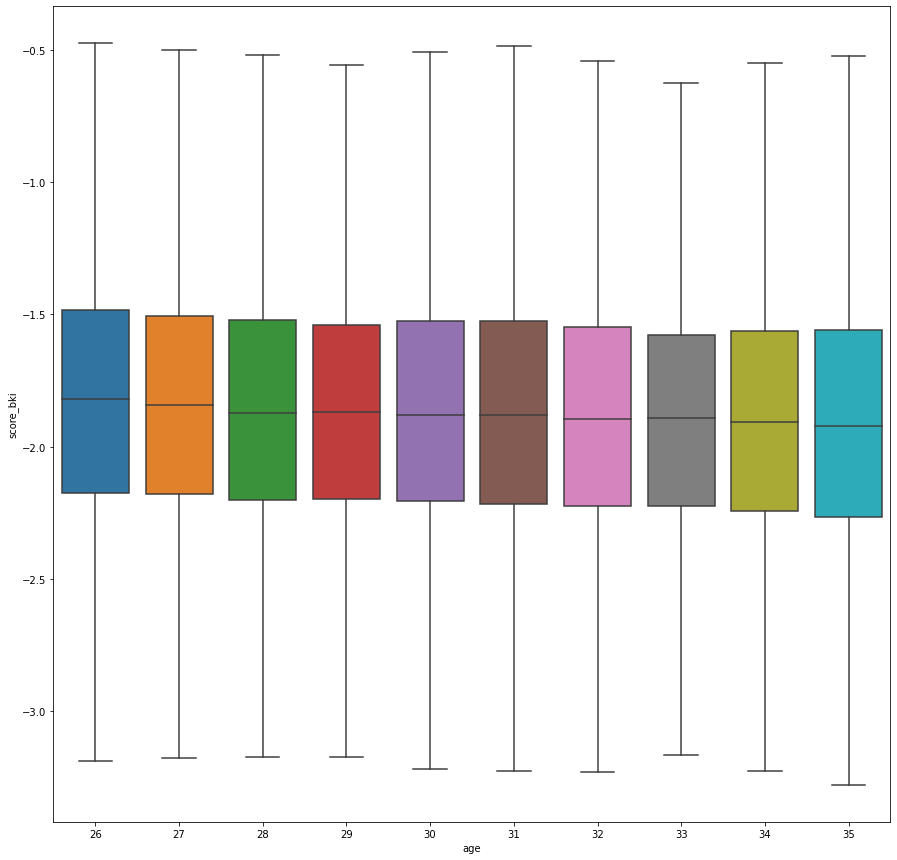

In [55]:
plt.figure(figsize=(15, 15))
sns.boxplot(x='age',
            y='score_bki',
            data=df[
                df.loc[:, 'age'
                      ].isin(
                    df.loc[
                        :, 'age'
                    ].value_counts().index[:10]
                )
            ],
            showfliers=False
)

The credit score data seems to be normally distributed, and it seems that usually credit score is a value from 600 to 800, so the data here is encoded. 
The data does not have any tails, but there are a few outliers on both ends, which will need to be removed.

People with higher(less negative) credit score seem to default more often, which seems counter intuitive. 

The higher the education, the lower(more negative) the scredit score is, except for the undegraduates. Most likely it is due to undergraduates being younger and not having a long credit hisotry to back up their credit score.

It is rather odd that clients with higher incomes do not really have a better(more negative) credit score.

Older people tend to have better(more negative) credit scores.

People who sent more credit score requests tend to have a worse(less negative) credit score. 

Those, who had rejected at least one application have a large spike in their credit score decrease(becoming less negative), but with the next conclussive rejection the decrease is not so drastic.

### 2.3.f Region Rating

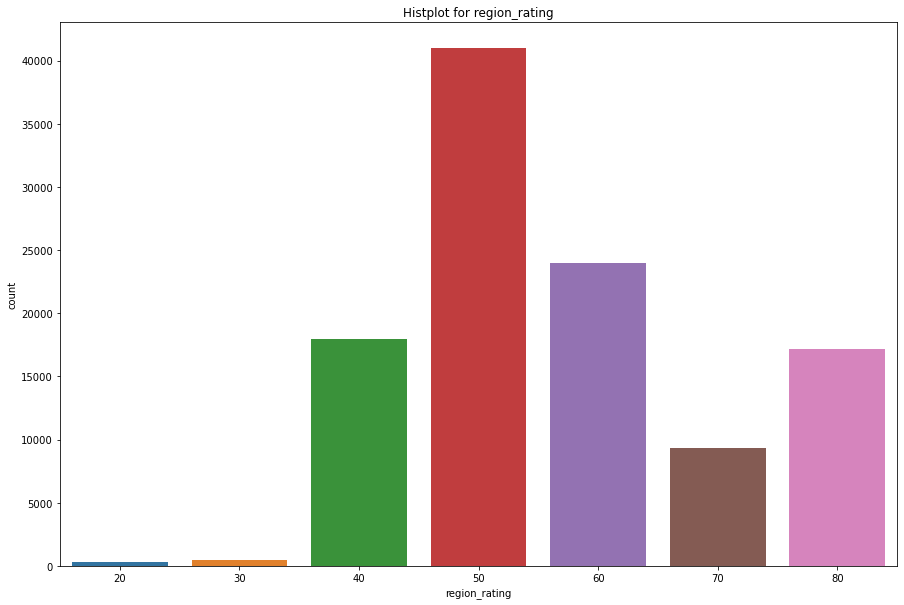

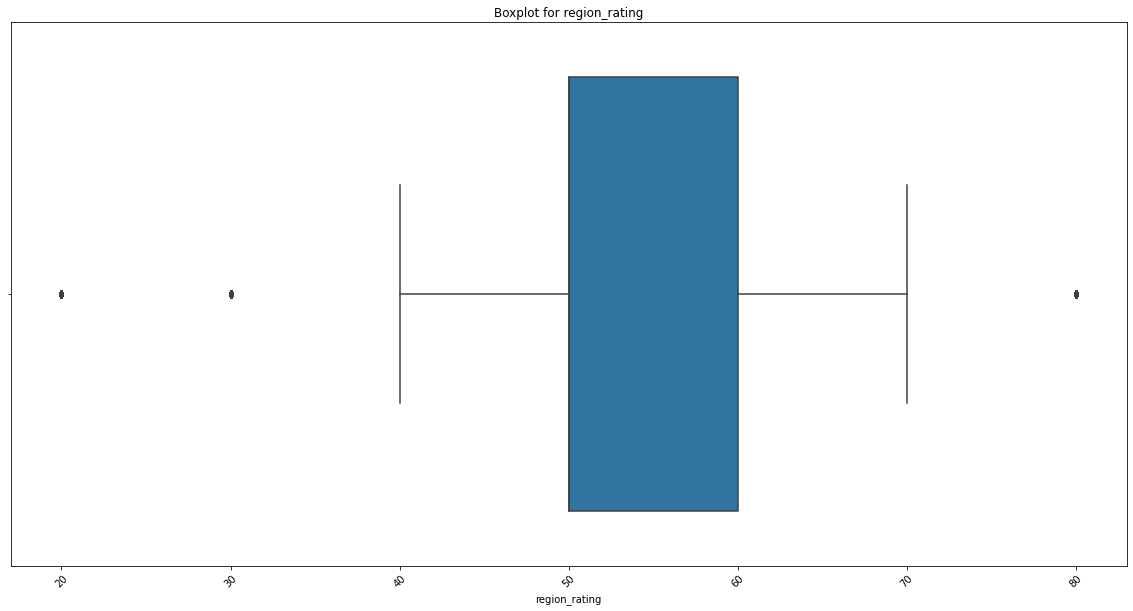

In [56]:
numerical_histplot('region_rating')
clear_boxplot('region_rating')

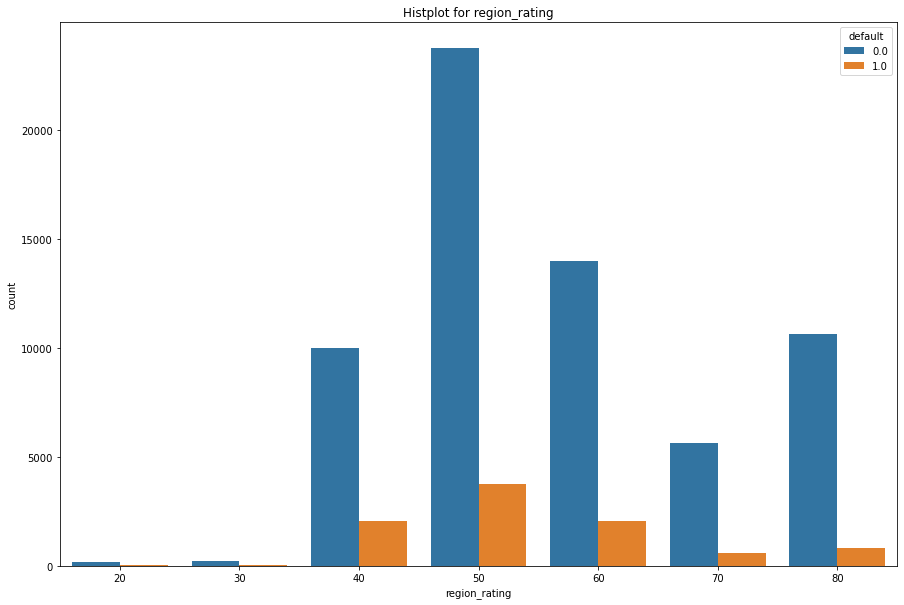

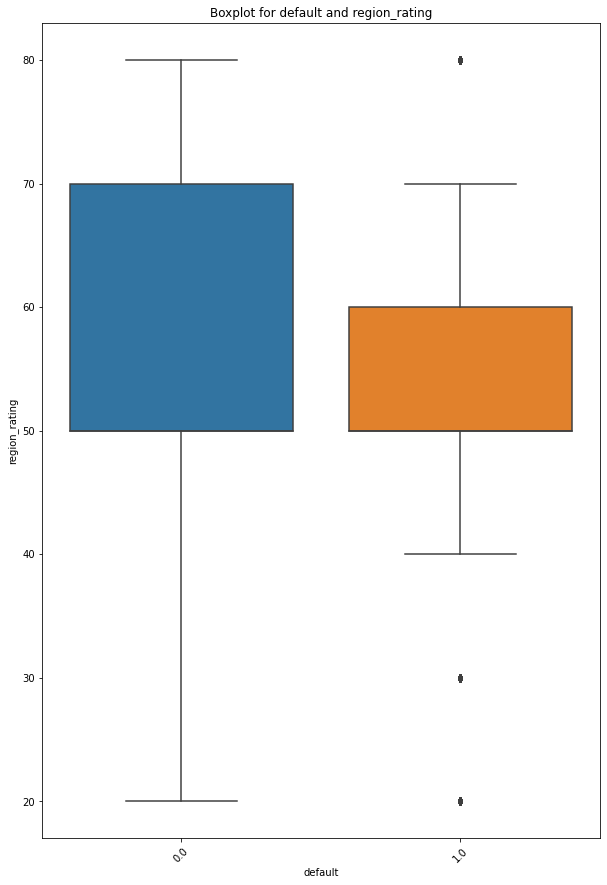

In [57]:
numerical_histplot('region_rating', hue=df['default'])
boxplot_numerical('region_rating')

This Column behaves more like a categorical data than the numerical.

In [58]:
display(df.region_rating.value_counts())
display(df.region_rating.value_counts(normalize=True))
display(
    df[df.default == 1].region_rating.value_counts(
        normalize=True
    )
)
percentage_of_defaulted('region_rating')

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

50    0.372054
60    0.217880
40    0.162935
80    0.155881
70    0.084468
30    0.003940
20    0.002842
Name: region_rating, dtype: float64

50    0.399808
60    0.220977
40    0.217776
80    0.089522
70    0.061140
30    0.006082
20    0.004695
Name: region_rating, dtype: float64

Fractions of defaulted clients in region_rating:


20    0.271605
30    0.234568
40    0.204386
50    0.157596
60    0.147886
70    0.101849
80    0.078928
Name: region_rating, dtype: float64

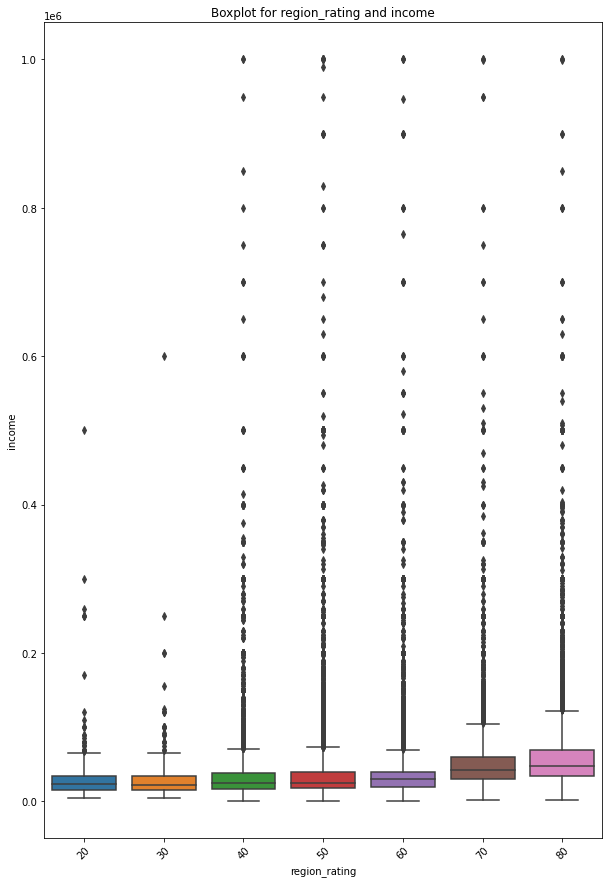

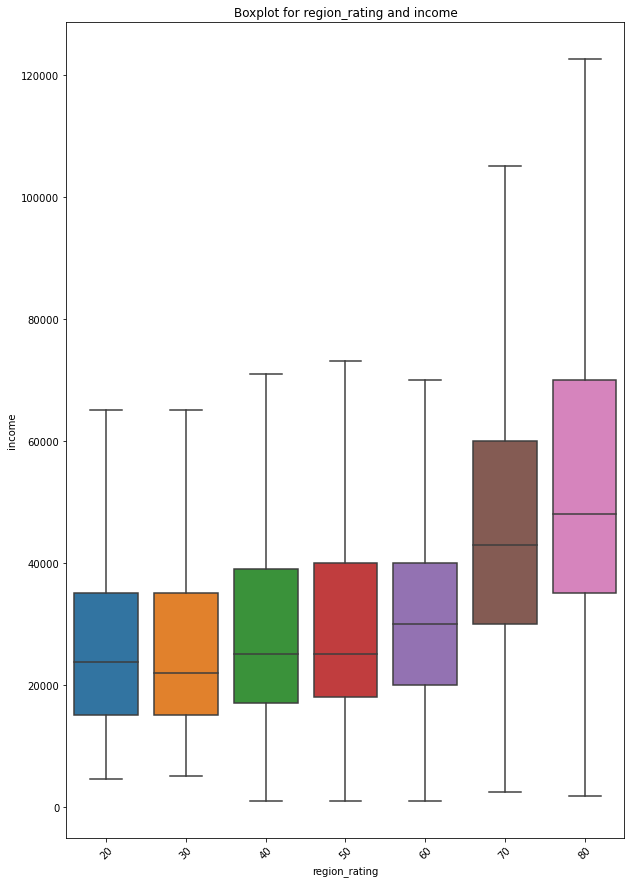

In [59]:
boxplot_numerical('income', 'region_rating', True)
boxplot_numerical('income', 'region_rating', False)

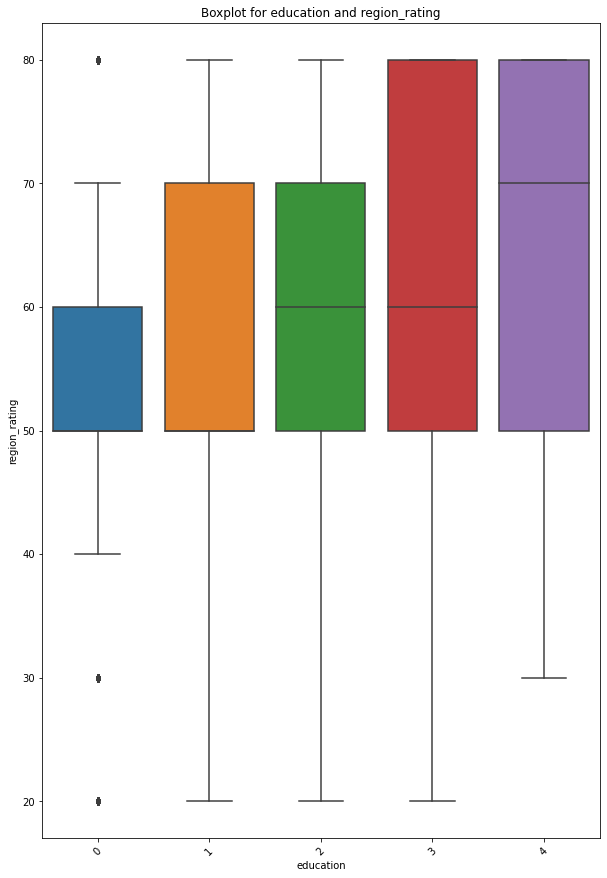

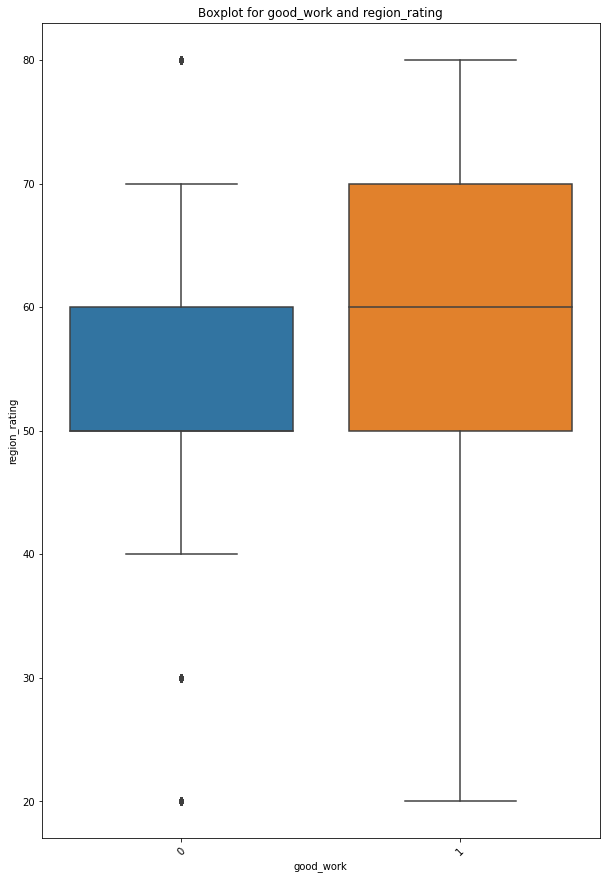

In [60]:
boxplot_numerical('region_rating', 'education')
boxplot_numerical('region_rating', 'good_work')

Replacing large numbers in categories with 0 to 6:

In [61]:
df['region_rating'] = df.region_rating.apply(region_rating_to_category)

Overall the distribution vaguely reminds of a normal distribution, but since the data given is discete, it was decided to treat it as a categorical data. 

In general, it seems that people from regions with higher rating tend to default less often. 

People with high income, education tend to live in  regions with higher rating.

It was unexpected that people with good jobs tend to have a bigger spread in region rating, having a lower boundary being 0 and upper of 6, while those who have normal jobs tend to live in the regions from the groups 2 to 5.

## 2.4 Date and Time

In [62]:
df['app_date'] = pd.to_datetime(df['app_date'])

In [63]:
df['month'] = df['app_date'].apply(lambda x: x.month)
df['weekend'] = df['app_date'].apply(if_weekend)
df['days_between'] = df['app_date'].apply(
    lambda x: (current_date-x))
date_time = ['weekend', 'month', 'days_between']

In [64]:
df['days_between'] = df['days_between'].apply(lambda x: x.days)

0    87789
1    22359
Name: weekend, dtype: int64

0    0.797009
1    0.202991
Name: weekend, dtype: float64

Fractions of defaulted clients in weekend:


0    0.144408
1    0.149643
Name: weekend, dtype: float64

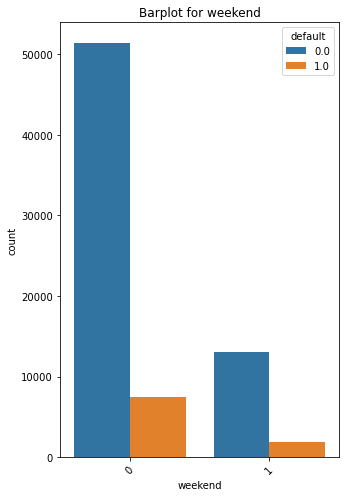

In [65]:
display(df.weekend.value_counts())
display(df.weekend.value_counts(normalize=True))
percentage_of_defaulted('weekend')
category_barplot('weekend')

3    31597
2    27097
4    26266
1    25188
Name: month, dtype: int64

3    0.286859
2    0.246005
4    0.238461
1    0.228674
Name: month, dtype: float64

Fractions of defaulted clients in month:


1    0.165966
2    0.152907
3    0.146182
4    0.118469
Name: month, dtype: float64

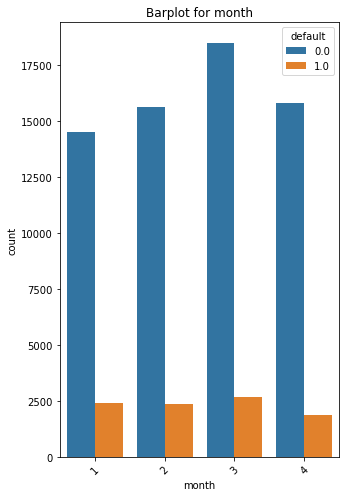

In [66]:
display(df.month.value_counts())
display(df.month.value_counts(normalize=True))
percentage_of_defaulted('month')
category_barplot('month')

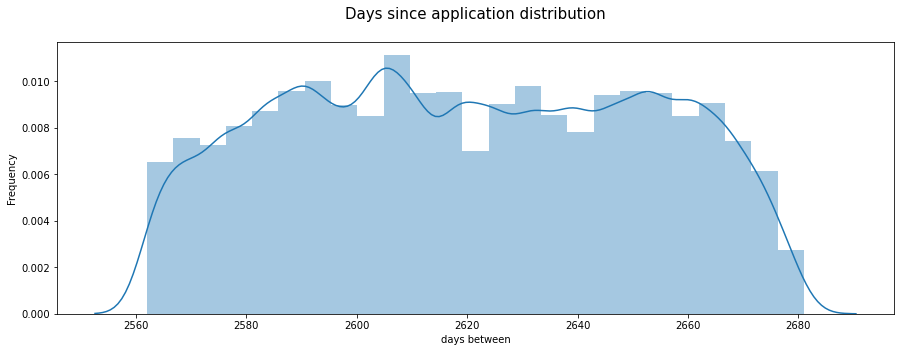

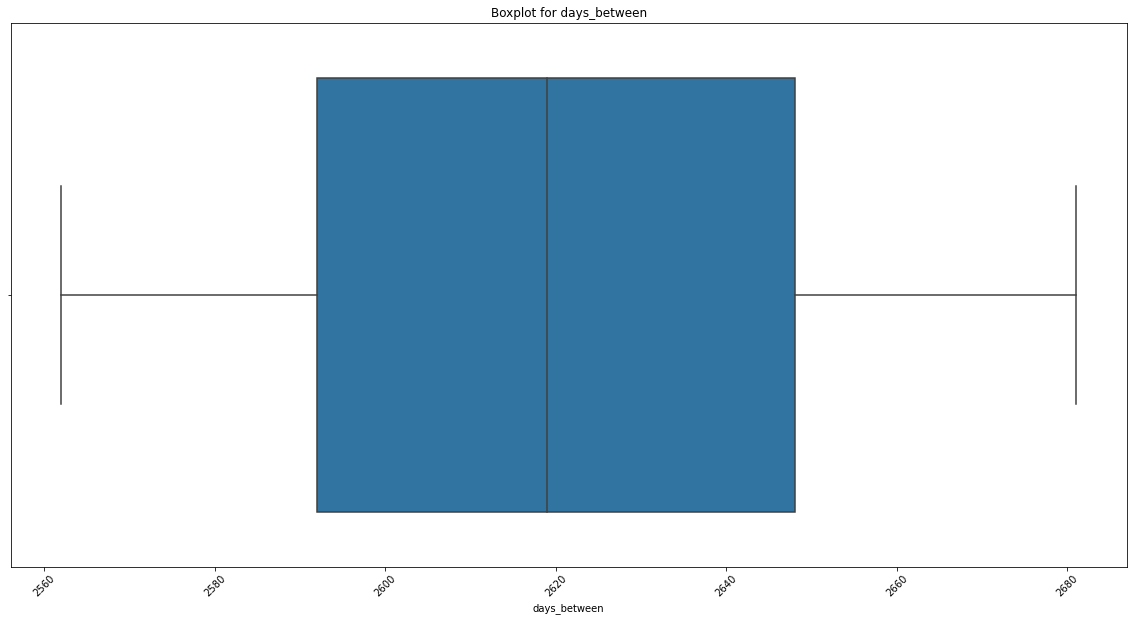

In [67]:
plt.figure(figsize=(15, 5))
sns.distplot(df.days_between.values, bins=25)
plt.title('Days since application distribution\n', fontsize=15)
plt.xlabel('days between')
plt.ylabel('Frequency')
clear_boxplot('days_between')

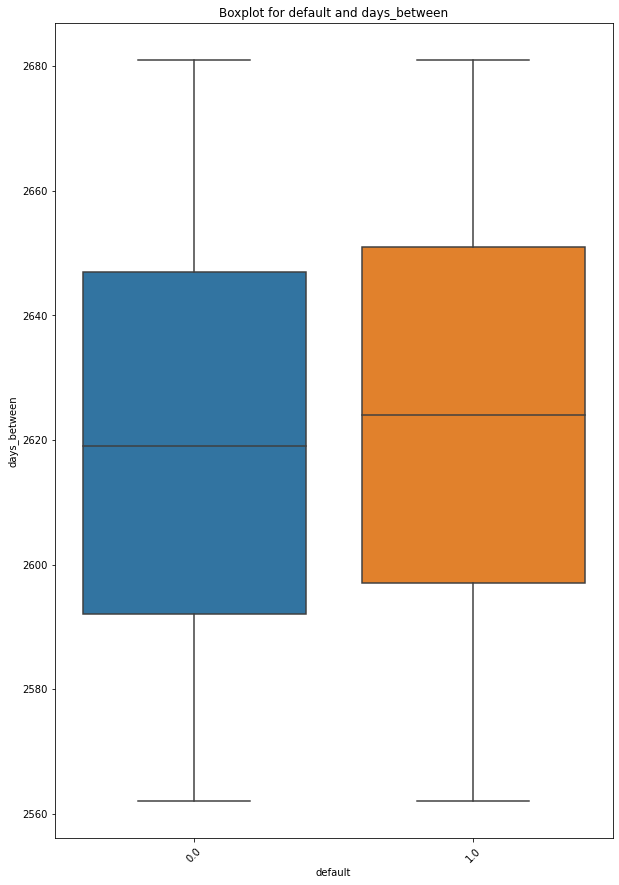

In [68]:
boxplot_numerical('days_between', sf=True)

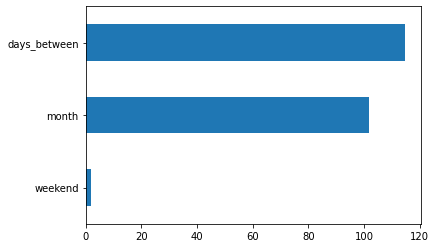

In [69]:
imp_num = pd.Series(
    f_classif(df[df['building_model'] == 1][date_time],
              df[df['building_model'] == 1]['default'])[0],
    index=date_time)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [70]:
df[date_time+['default']].corr()

,weekend,month,days_between,default
weekend,1.000000,-0.001504,0.019541,0.004807
month,-0.001504,1.000000,-0.964939,-0.037115
days_between,0.019541,-0.964939,1.000000,0.039372
default,0.004807,-0.037115,0.039372,1.000000


Date time columns will be added to binary, category and numerical. Month and days between have a very strong correlation, so month column will be dropped. None of the date time data has a strong correlation with the target variable. 

It appears that those who made applications later defaulted less often. 

In [71]:
df = df.drop(['month'], axis=1)
numerical += ['days_between']
binary += ['weekend']

## 2.5 Target value

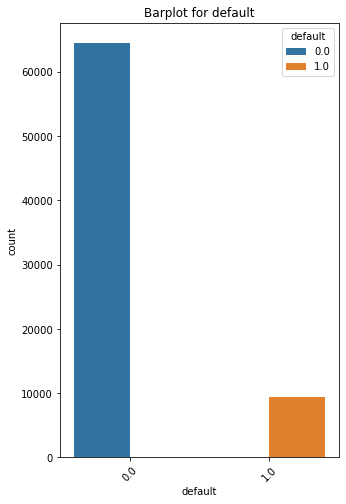

In [72]:
category_barplot('default')

The target value is very unbalanced, so the model will favour the result of 0. To increase it's accuracy oversampling or undersampling will take place.

## 2.6 Correlations and Encoding

In [73]:
numerical.remove('region_rating')
category += ['region_rating']

In [74]:
binary, category, numerical

(['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'weekend'],
 ['education',
  'work_address',
  'home_address',
  'sna',
  'first_time',
  'region_rating'],
 ['age',
  'decline_app_cnt',
  'bki_request_cnt',
  'income',
  'score_bki',
  'days_between'])

### 2.6.a Binary and Categories
Now that the model can interpret the data, the effect of the categories on the target value should be found. Also the data will be encoded so the model can interprite it:

In [75]:
label_encoder = LabelEncoder()  # ecoder
for column in binary[:-1]:
    df[column] = label_encoder.fit_transform(df[column])
df[binary+category]

,sex,car,car_type,good_work,foreign_passport,weekend,education,work_address,home_address,sna,first_time,region_rating
0,1,1,1,0,0,1,0,2,1,4,1,3
1,0,0,0,0,0,0,0,3,2,4,1,3
2,1,1,0,0,1,1,0,2,1,1,4,6
3,0,0,0,0,0,0,0,3,2,1,3,3
4,1,0,0,1,1,0,2,3,2,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,0,0,0,0,0,0,3,2,4,1,3
110144,0,1,1,0,0,0,2,2,1,1,4,4
110145,1,0,0,0,0,1,2,2,1,4,2,3
110146,0,0,0,0,0,0,1,3,2,1,1,6


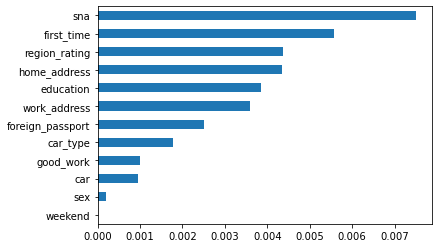

In [76]:
imp_cat = pd.Series(mutual_info_classif(
    df[df['building_model'] == 1][binary + category],
    df[df['building_model'] == 1]['default'], discrete_features=True),
                 index=binary + category)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

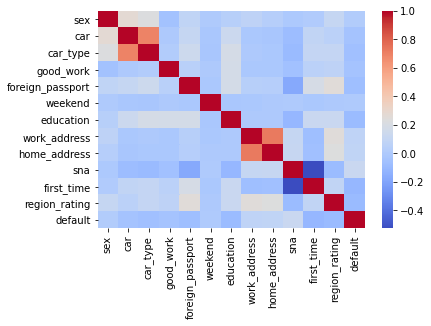

In [77]:
sns.heatmap(df[binary+category+['default']].corr(),
            cmap='coolwarm')

Out of all categorical data it seems that SNA and first_time have the highest impact on target value. 
A fairly strong correlation can be seen between the work and home addresses, and between the car and car_type.
First_time and sna have a fairly strong negative correlation between the two.
None of the categories has a strong correlation with a target value.

### 2.6.b Numerical
Initially, score_bki was not supposed to be logged, but eventually the decision was taken to log it. It resulted in a minor improvement of results. Due to score-bki having many negative values, a constant of 4 is added to get rid of them. It will slightly shift the other columns to the right, bu will not affect the distribution pattern.

In [78]:
for column in numerical:
    df[column] = df[column].apply(lambda x: np.log(x+4))

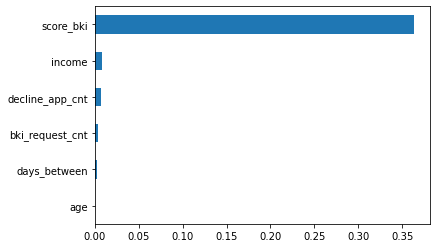

In [79]:
df[numerical] = StandardScaler().fit_transform(df[numerical])
imp_cat = pd.Series(mutual_info_classif(
    df[df['building_model'] == 1][numerical],
    df[df['building_model'] == 1]['default'], discrete_features=True),
                 index=numerical)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

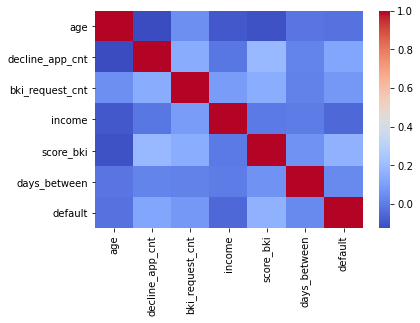

In [80]:
sns.heatmap(df[numerical+['default']].corr(),
            cmap='coolwarm')

Credit score appears to be the most important numerical value. There are no strong correlations between the nuemrical values, and most of them have a positive correlation between each other.
None of the numerical values has a strong correlation with the target value.

### 2.6.c Total

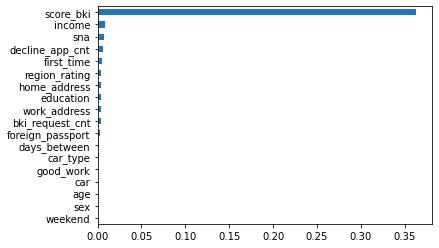

In [81]:
imp_cat = pd.Series(mutual_info_classif(
    df[df['building_model'] == 1][numerical+binary+category],
    df[df['building_model'] == 1]['default'], discrete_features=True),
                 index=numerical+binary+category)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

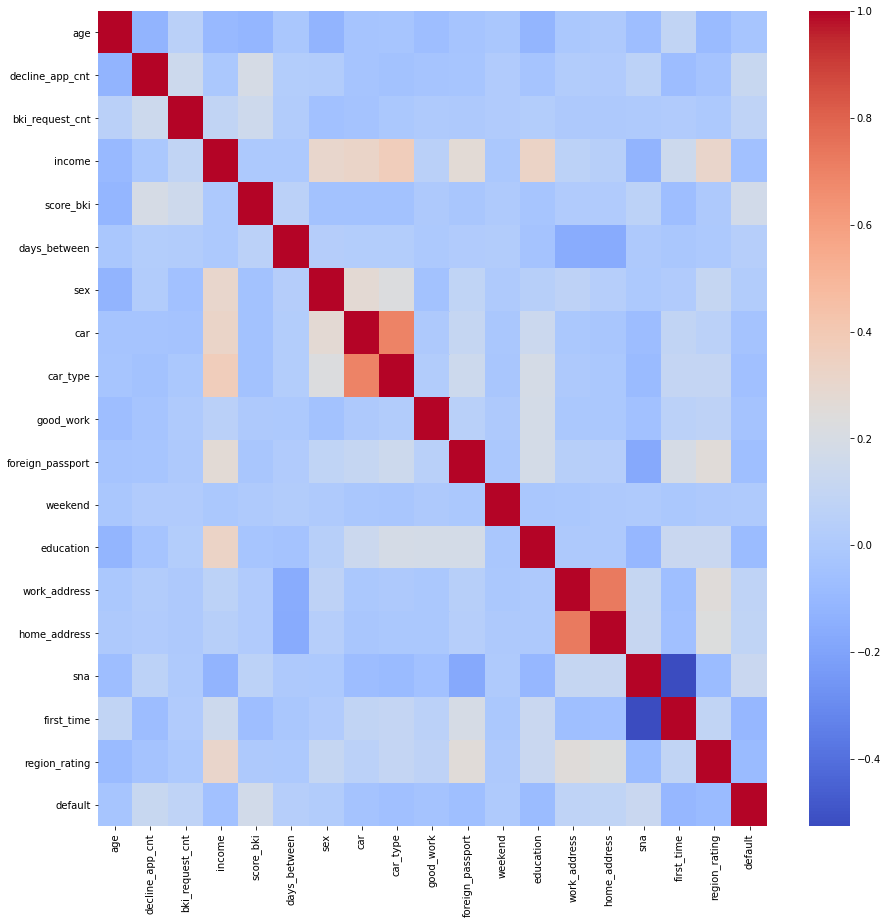

In [82]:
plt.figure(figsize=(15, 15))
sns.heatmap(df[numerical+binary+category+['default']].corr(),
            cmap='coolwarm')

# 3. Feature Engineering

## 3.1 Car
Car and car_type column can be combined to make a single column with car_type. 

In [83]:
binary.remove('car_type')
binary.remove('car')
category.append('car')
df['car'] += df['car_type']
df.drop('car_type', axis=1)
df['car'].value_counts()

0    74290
2    21008
1    14850
Name: car, dtype: int64

1. 0 - has no car
2. 1 - has a car
3. 2 - has an imported car

## 3.2 credit score outliers
In the previous section it was established that many numerical columns have plenty of outliers. Some of them should be removed to increase the accuracy of the future model:

In [84]:
percentile('score_bki')
df = df.loc[
    (df.score_bki.between(lower_boundary, upper_boundary)) |
    (df.default.isna())]

Lower boundary: -2.6334455317411214
Upper boundary: 2.7246230412374493


## 3.3 Income
Income column has the most extreme outliers, for the first iteration of the model they will be removed.

This showed to be ineffective, but the code is kept in case it's needed.

In [85]:
# percentile('income')
# df = df.loc[
#    (df.income.between(lower_boundary, upper_boundary)) |
#    (df.default.isna())]

## 3.4 Credit score requests
Getting rid of the outliers in bki_request_cnt

In [86]:
percentile('bki_request_cnt')
df = df.loc[
    (df.bki_request_cnt.between(lower_boundary, upper_boundary)) |
    (df.default.isna())]

Lower boundary: -3.854490393012595
Upper boundary: 3.379596056671067


## 3.5 Preparing data
Preparing the data for the model

In [87]:
df_model = df.loc[df.building_model == 1]
X = df_model[numerical + category + binary].values
Y = df_model['default'].values

# 4. Logistic regression

### 4.1 Simple regression
At first, the moel will be build with no hyperparameters and no over or under -sampling, to see how the model will do. 

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=0.20,
                                                  random_state=42)
log_reg_simpl = LogisticRegression()
log_reg_simpl.fit(X_train, y_train)

LogisticRegression()

In [89]:
probs = log_reg_simpl.predict_proba(X_val)
probs = probs[:, 1]
y_pred = log_reg_simpl.predict(X_val)

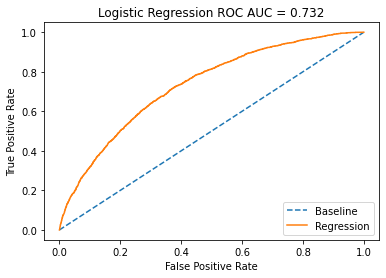

accuracy_score: 0.8706813489332416
precision_score: 0.524390243902439
recall_score: 0.022835900159320233
f1_score: 0.04376590330788804


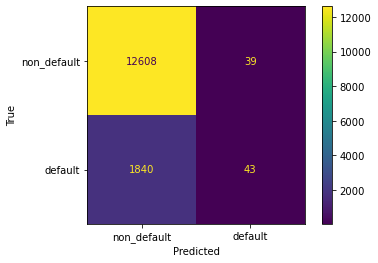

In [90]:
fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
metrics(y_val, y_pred)

While roc_auc and accucary values appear to be fairly high, recall and f1 score is abyssmaly low. The model clearly favours non_default outcome, which was expected in section 2.5. At first the class_weight will be set to balanced:

## 4.2 Logistic Regression with balanced class weight

In [91]:
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=0.20,
                                                  random_state=42)
log_reg_balanced = LogisticRegression(class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [92]:
probs = log_reg_balanced.predict_proba(X_val)
probs = probs[:, 1]
y_pred = log_reg_balanced.predict(X_val)

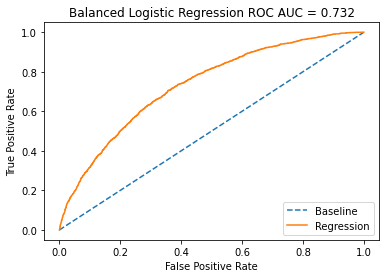

accuracy_score: 0.6654507914659326
precision_score: 0.22966594045025418
recall_score: 0.6718003186404673
f1_score: 0.3423082126911108


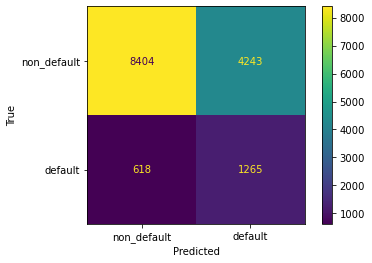

In [93]:
fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Balanced Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
metrics(y_val, y_pred)

The results have clearly improved, roc_auc value was not affected, but the number of false negative results was reduced massively. The number of false positive outcomes increased. To attempt to improve the model, undersampling and oversampling will take place.

## 4.3 Oversampling and undersampling

### 4.3.a Preparation
Preparing X and Y with oversampling and undersampling

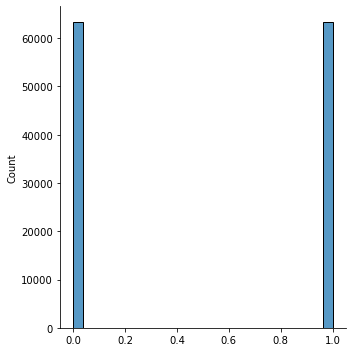

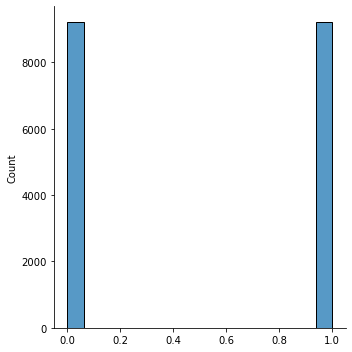

In [94]:
oversample = RandomOverSampler()
X_over, Y_over = oversample.fit_resample(X, Y)
sns.displot(Y_over)
undersample = RandomUnderSampler()
X_under, Y_under = undersample.fit_resample(X, Y)
sns.displot(Y_under)

### 4.3.b Logistic Regression with oversampling

In [95]:
X_train_o, X_val_o, y_train_o, y_val_o = train_test_split(X_over,
                                                          Y_over,
                                                          test_size=0.20,
                                                          random_state=42)
log_reg_over = LogisticRegression()
log_reg_over.fit(X_train_o, y_train_o)

LogisticRegression()

In [96]:
probs_o = log_reg_over.predict_proba(X_val_o)
probs_o = probs_o[:, 1]
y_pred_o = log_reg_over.predict(X_val_o)

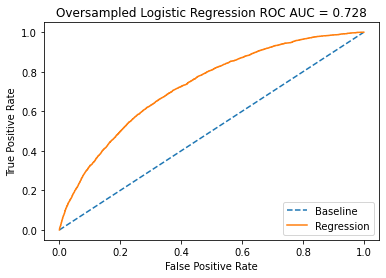

accuracy_score: 0.6653658152002523
precision_score: 0.6598597038191738
recall_score: 0.6723850369311413
f1_score: 0.6660634908146807


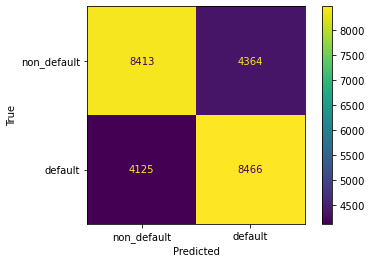

In [97]:
fpr, tpr, threshold = roc_curve(y_val_o, probs_o)
roc_auc = roc_auc_score(y_val_o, probs_o)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Oversampled Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
metrics(y_val_o, y_pred_o)

It appears that oversampling increased all the metrics present. Accucary, precision, recall and f1 score all went up, so the model is much more accurate now.

## 4.3.c Logistic regression with undersampling

In [98]:
X_train_u, X_val_u, y_train_u, y_val_u = train_test_split(X_under,
                                                          Y_under,
                                                          test_size=0.20,
                                                          random_state=42)
log_reg_under = LogisticRegression()
log_reg_under.fit(X_train_u, y_train_u)

LogisticRegression()

In [99]:
probs_u = log_reg_under.predict_proba(X_val_u)
probs_u = probs_u[:, 1]
y_pred_u = log_reg_under.predict(X_val_u)

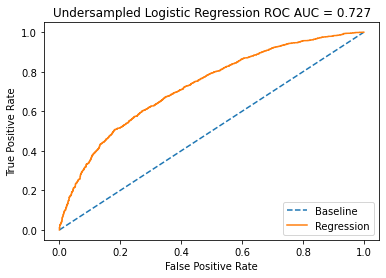

accuracy_score: 0.659534127843987
precision_score: 0.649104320337197
recall_score: 0.675809105869446
f1_score: 0.6621875839828003


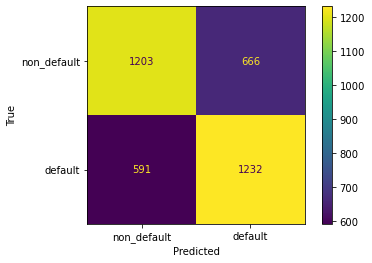

In [100]:
fpr, tpr, threshold = roc_curve(y_val_u, probs_u)
roc_auc = roc_auc_score(y_val_u, probs_u)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Undersampled Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
metrics(y_val_u, y_pred_u)

Just like oversampling, undesampling produces much better results, yet it appears that it is slighly less effective than oversampling.

Let's see how hyperparameters will affect it.

## 4.4 Logistic Regression with hyperparameters
Since oversmpling showed itself to be the most effective, it will be used from now on for Logistic Regression

In [101]:
param = {
    'C': np.linspace(0.001, 10, 10),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced'],
    'multi_class': ['auto', 'ovr'],
    'max_iter': [50],
    'tol': [1e-3]}

clf = GridSearchCV(log_reg_over,
                   param,
                   scoring='roc_auc',
                   refit=True,
                   cv=5,
                   verbose=False)

log_reg_hyper = clf.fit(X_train_u, y_train_u)

# View best hyperparameters
log_reg_hyper.best_estimator_.get_params()

{'C': 4.445,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 50,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.001,
 'verbose': 0,
 'warm_start': False}

In [102]:
probs = log_reg_hyper.predict_proba(X_val_u)
probs = probs[:, 1]
y_pred = log_reg_hyper.predict(X_val_u)

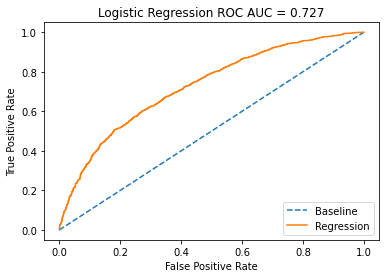

accuracy_score: 0.661430119176598
precision_score: 0.6516675489677077
recall_score: 0.6752605595172793
f1_score: 0.6632543103448276


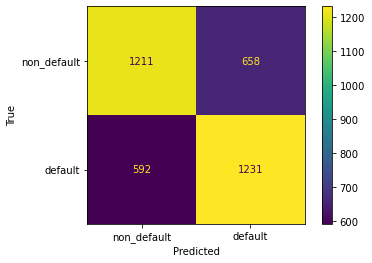

In [103]:
fpr, tpr, threshold = roc_curve(y_val_u, probs)
roc_auc = roc_auc_score(y_val_u, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
metrics(y_val_u, y_pred)

Hyperparameters did not affect the metrics by any significant measure. Logistic regression with oversampling appears to be the most effective so far.

## 4.5 Simple RandomForestClassifier

In [104]:
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=0.20,
                                                  random_state=42)
rfc_simple = RandomForestClassifier()
rfc_simple.fit(X_train, y_train)

RandomForestClassifier()

In [105]:
rfc_probs = rfc_simple.predict_proba(X_val)
rfc_probs = rfc_probs[:, 1]
y_pred_rfc = rfc_simple.predict(X_val)

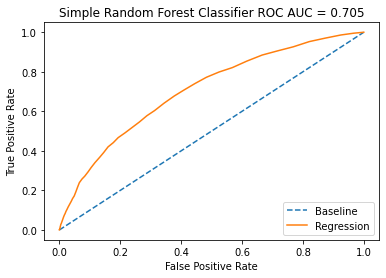

accuracy_score: 0.8701995870612526
precision_score: 0.48
recall_score: 0.019118428040361127
f1_score: 0.03677221654749745


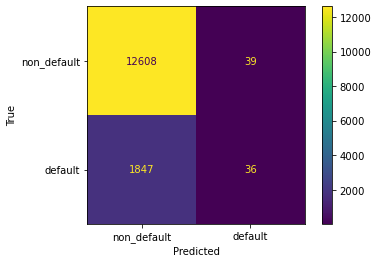

In [106]:
fpr, tpr, threshold = roc_curve(y_val, rfc_probs)
roc_auc = roc_auc_score(y_val, rfc_probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Simple Random Forest Classifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
metrics(y_val, y_pred_rfc)

Random forest regression suffers from the same problem as logistics regression - the data has too many rows with default = 0, so the model tends to predict most things with 0. Oversampling and undersampling will be added.

## 4.6.a Undersampling Random Forest Classifier

In [107]:
X_train_u, X_val_u, y_train_u, y_val_u = train_test_split(X_under,
                                                          Y_under,
                                                          test_size=0.20,
                                                          random_state=42)
rfc_under = RandomForestClassifier()
rfc_under.fit(X_train_u, y_train_u)

RandomForestClassifier()

In [108]:
rfc_probs = rfc_under.predict_proba(X_val_u)
rfc_probs = rfc_probs[:, 1]
y_pred_rfc = rfc_under.predict(X_val_u)

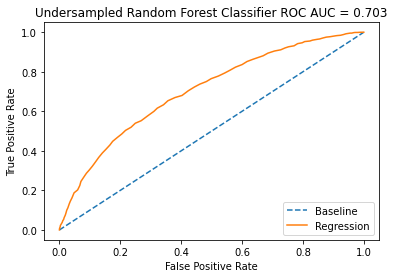

accuracy_score: 0.6484290357529794
precision_score: 0.6413570274636511
recall_score: 0.6533187054306089
f1_score: 0.6472826086956522


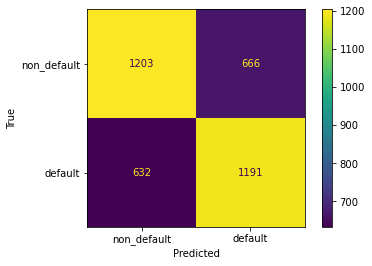

In [109]:
fpr, tpr, threshold = roc_curve(y_val_u, rfc_probs)
roc_auc = roc_auc_score(y_val_u, rfc_probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Undersampled Random Forest Classifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
metrics(y_val_u, y_pred_rfc)

With no hyperparameters the model appears to be less effective than it's logistic regression counterpart.

## 4.6.b Oversampled Random Forest Classifier

In [110]:
X_train_o, X_val_o, y_train_o, y_val_o = train_test_split(X_over,
                                                          Y_over,
                                                          test_size=0.20,
                                                          random_state=42)
rfc_over = RandomForestClassifier()
rfc_over.fit(X_train_o, y_train_o)

RandomForestClassifier()

In [111]:
rfc_probs = rfc_over.predict_proba(X_val_o)
rfc_probs = rfc_probs[:, 1]
y_pred_rfc = rfc_over.predict(X_val_o)

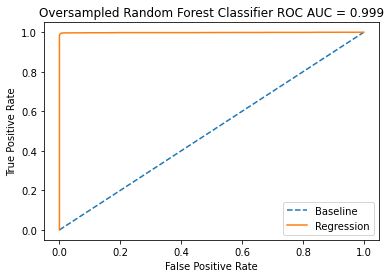

accuracy_score: 0.9820245979186376
precision_score: 0.9678464029609067
recall_score: 0.9969025494400763
f1_score: 0.9821596244131455


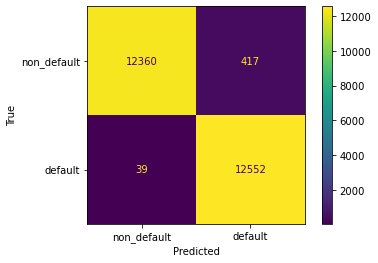

In [112]:
fpr, tpr, threshold = roc_curve(y_val_o, rfc_probs)
roc_auc = roc_auc_score(y_val_o, rfc_probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Oversampled Random Forest Classifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
metrics(y_val_o, y_pred_rfc)

While the reason of such result is unclear, common sense tells that it is not working as intended.

## 4.7 Oversampled Random Forest Classifier with hyperparameters

In [113]:
X_train_o, X_val_o, y_train_o, y_val_o = train_test_split(X_over,
                                                          Y_over,
                                                          test_size=0.20,
                                                          random_state=42)
rfc_o_hyper = RandomForestClassifier()
rfc_o_hyper.fit(X_train_o, y_train_o)

param = {
    'bootstrap': [True],
    'max_depth': [5, 10],
    'n_estimators': [100, 200],
    'max_features': [4],
    'criterion': ['gini', 'entropy'],
    'warm_start': [False],
    'ccp_alpha': [0, 1]
}
clf = GridSearchCV(rfc_o_hyper,
                   param,
                   scoring='roc_auc',
                   refit=True,
                   cv=5,
                   verbose=False)

rfc_o_hyper = clf.fit(X_train_o, y_train_o)
rfc_o_hyper.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 4,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [114]:
rfc_probs = rfc_o_hyper.predict_proba(X_val_o)
rfc_probs = rfc_probs[:, 1]
y_pred_rfc = rfc_o_hyper.predict(X_val_o)

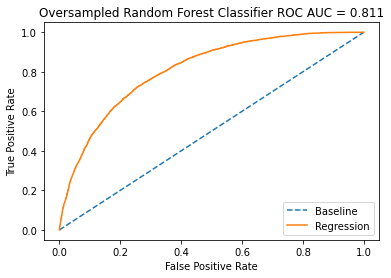

accuracy_score: 0.7312756228319143
precision_score: 0.7149344848123883
recall_score: 0.7626876340243031
f1_score: 0.7380394266610306


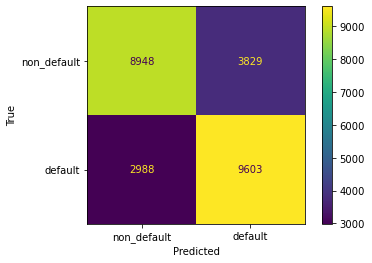

In [115]:
fpr, tpr, threshold = roc_curve(y_val_o, rfc_probs)
roc_auc = roc_auc_score(y_val_o, rfc_probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Oversampled Random Forest Classifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
metrics(y_val_o, y_pred_rfc)

accuracy_score: 0.7548586746560492
precision_score: 0.7430556856281256
recall_score: 0.7805103586676373
f1_score: 0.7613226375988332


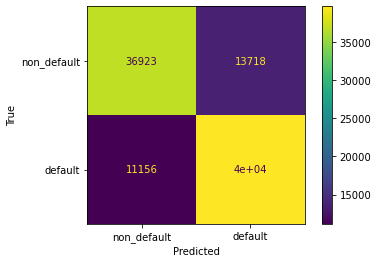

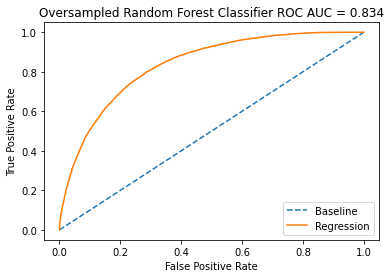

In [116]:
rfc_probs_tech = rfc_o_hyper.predict_proba(X_train_o)
rfc_probs_tech = rfc_probs_tech[:, 1]
y_tech_rfc = rfc_o_hyper.predict(X_train_o)
metrics(y_train_o, y_tech_rfc)
fpr, tpr, threshold = roc_curve(y_train_o, rfc_probs_tech)
roc_auc = roc_auc_score(y_train_o, rfc_probs_tech)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Oversampled Random Forest Classifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

The model appears to be slightly overtrained, but overall shows good results. 
Checking the model on a non-oversampled data:

accuracy_score: 0.7271163110805231
precision_score: 0.2898667743237788
recall_score: 0.7626128518321826
f1_score: 0.4200672809711862


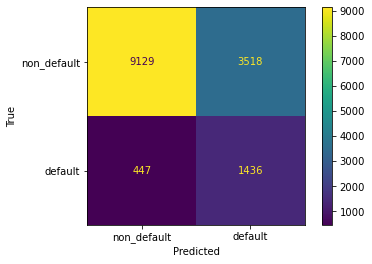

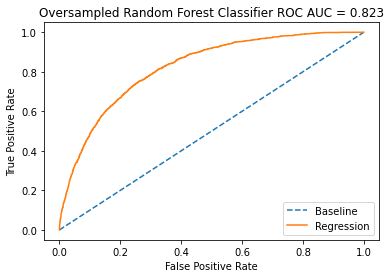

In [117]:
# This section can be used to check how efficient the model is
# on non-oversampled data.

rfc_probs_tech = rfc_o_hyper.predict_proba(X_val)
rfc_probs_tech = rfc_probs_tech[:, 1]
y_tech_rfc = rfc_o_hyper.predict(X_val)
metrics(y_val, y_tech_rfc)
fpr, tpr, threshold = roc_curve(y_val, rfc_probs_tech)
roc_auc = roc_auc_score(y_val, rfc_probs_tech)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Oversampled Random Forest Classifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Despite showing an amazing value of roc auc, high recall score and fairly high accuracy, the model's f1 score is fairly low, while precision score is horrific. The model does a mistake of 2nd kind, where ity considers too many clients as default ones. 

# 6. Submission

In [118]:
# creating the X value for the model
df_sub = df.loc[df.default.isna()]
X_sub = df_sub[numerical + category + binary].values

In [119]:
model = log_reg_hyper  # choice of a model

In [120]:
df_sub['default'] = model.predict_proba(X_sub)

Text(0, 0.5, 'Frequency')

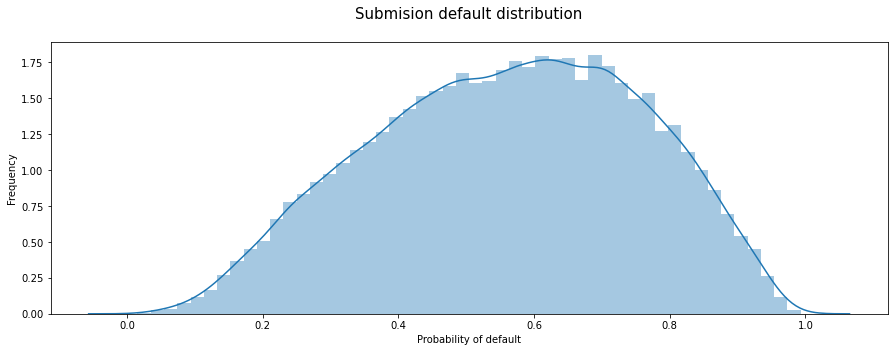

In [121]:
plt.figure(figsize=(15, 5))
sns.distplot(df_sub['default'].values, bins=50)
plt.title('Submision default distribution\n', fontsize=15)
plt.xlabel('Probability of default')
plt.ylabel('Frequency')

The results appear to be shifted to the right, which contradicts the initial trend. Since there are more non-defaulted clients. It appears that algorithm predicts a probability of non-defaulting?

In [122]:
# As a temporary crutch, flip the probabilites
df_sub['default'] = df_sub['default'].apply(lambda x: 1-x)

Text(0, 0.5, 'Frequency')

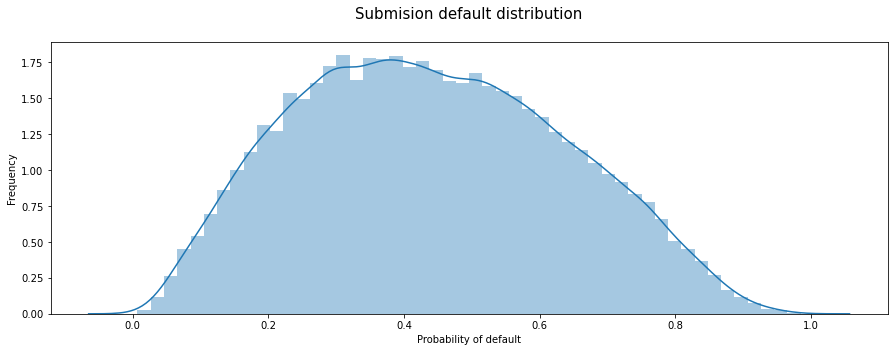

In [123]:
plt.figure(figsize=(15, 5))
sns.distplot(df_sub['default'].values, bins=50)
plt.title('Submision default distribution\n', fontsize=15)
plt.xlabel('Probability of default')
plt.ylabel('Frequency')

In [124]:
submission = df_sub[['client_id', 'default']]

In [125]:
submission.to_csv('submission.csv', index=False)

# Conclusions
## 1. What went well
Overall, the data visualisation and analysis went quite well. I managed to find different connections between diffrent columns and have a good look at the data. Feature Engineering section also went somewhat well, with an extra few columns being added. 

I managed to have a look at 3 different machine learning algorithms used for the same task, them being LogsiticRegression, kneighborsclassifier and RandomForestClassifier.

I got to work with hyperparameters, and I got a better undestanding of what they are, how to use them and how to find them.

## 2. What did not go well
Despite the use of hyperparameters and different models, the target value is well below the one I wanted to get. I was aiming for roc auc of 0.737+ on validation on Kaggle, yet I got 0.73371. 

The use of different classification algorithms did not help much, and did not impact the accucacy overall, even tho randomforestclassifier did show an insane 0.802 roc auc value with high f1 and accuracy, the model showed to be ineffectve and predict too many positive(defaulted) outcomes. 

The most odd thing is that all algorithms for some reason predicted the probability of not defaulting, resulting in a really low Kaggle validation score(around 0.2), so a small 'crutch' had to be implemented. The reason of this is unclear. 

## 3. Questionable descisions and their reasoning

I had a few ways of how I wanted to visualise data, yet I stuck to large graphs instead of small subblots side by side. In my opinion, they allow for a better look at the data. 

Perhabs a better idea would be to use pie charts instead of barplots, or use both of them. Piecharts would make the graphs much more easy to read and undestand. 
